In [1]:
#!/usr/bin/env python
# -*-coding:utf-8 -*-
'''
@File    :   phishing-graphs.ipynb
@Time    :   2023/03/30 21:02:43
@Author  :   Patricia Hernando Fernández 
@Version :   1.0
@Contact :   phf1001@alu.ubu.es
'''


'\n@File    :   phishing-graphs.ipynb\n@Time    :   2023/03/30 21:02:43\n@Author  :   Patricia Hernando Fernández \n@Version :   1.0\n@Contact :   phf1001@alu.ubu.es\n'

# **PHISHING EXPERIMENTS**

In [2]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    recall_score,
    precision_score,
    auc,
    roc_curve,
    precision_recall_curve,
    accuracy_score,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
import seaborn as sns

# Changing paths to src
src_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(src_path)
from models.classifiers.DemocraticCoClassifier import DemocraticCo
from models.classifiers.TriTrainingClassifier import TriTraining
from models.classifiers.CoForestClassifier import CoForest

In [3]:
def get_clss(rd=5):
    # Random Forest
    random_forest_all = RandomForestClassifier(
        6, max_features="log2", random_state=rd
    )

    # Co Forest
    co_forest_six = CoForest(6, 0.75, max_features="log2", random_state=rd)
    co_forest_twenty = CoForest(20, 0.75, max_features="log2", random_state=rd)

    # Tri Training
    tri_training = TriTraining(
        DecisionTreeClassifier(),
        GaussianNB(),
        KNeighborsClassifier(),
        random_state=rd,
    )

    # Democratic Co
    democratic_co = DemocraticCo(
        [DecisionTreeClassifier(), GaussianNB(), KNeighborsClassifier()],
        random_state=rd,
    )

    cls = [
        random_forest_all,
        democratic_co,
        co_forest_six,
        co_forest_twenty,
        tri_training,
    ]
    
    cls_names = ["RF", "DC", "CoF_CLT", "CoF_PL", "TT"]

    return cls, cls_names

In [4]:
def get_first_last_feature(features):
    if features == "F1-F8":
        return 0, 8

    if features == "F9":
        return 8, 9

    if features == "F10-F15":
        return 9, 15

    if features == "F16":
        return 15, 16

    if features == "F17-F19":
        return 16, 19

    return 0, 19

In [5]:
def get_folds(features="all", rd=5):
    df = pd.read_csv(filepath_or_buffer="./fv/results-5_fvg3/mix.csv")
    first_feature, last_feature = get_first_last_feature(features)
    X = df[df.columns[first_feature:last_feature]].values
    y = df.tag.values.astype(int)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rd)

    return X, y, skf

In [6]:
def get_comparation_graph(cls, cls_names, X, y, skf, rd=5, y_low_lim=0, curve='ROC', used_features='F1-F19'):

    fig, axes = plt.subplots(1, 5, figsize=(15, 3.5), tight_layout=True)
    colours = ["#82e0aa", "#3eccf6", "#de88f3", "#f39c12", "#ff6961"]
    scores = []
    recalls = []
    precisions = []
    f1s = []
    AUCs = []
    y_true_total = []
    y_preds_total = {cls_name: [] for cls_name in cls_names}

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        L_train, U_train, Ly_train, Uy_train = train_test_split(
            X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train
        )

        scores_experiment = []
        recalls_experiment = []
        precisions_experiment = []
        AUCs_experiment = []
        f1s_experiment = []

        for cl, cl_name in zip(cls, cls_names):
            if cl_name == "RF":
                cl.fit(X_train, y_train)
            elif cl_name == "CoF_CLT":
                cl.fit(
                    L_train,
                    Ly_train,
                    U_train,
                    w_init_criteria="confidence_L_all",
                )
            elif cl_name == "CoF_PL":
                cl.fit(
                    L_train, Ly_train, U_train, w_init_criteria="percentage_L"
                )
            else:
                cl.fit(L_train, Ly_train, U_train)

            y_pred = cl.predict(X_test)
            scores_experiment.append(accuracy_score(y_test, y_pred))
            recalls_experiment.append(recall_score(y_test, y_pred))
            precisions_experiment.append(precision_score(y_test, y_pred))
            f1s_experiment.append(f1_score(y_test, y_pred))
            y_preds_total[cl_name] += list(y_pred)

            if curve == "ROC":
                fpr, tpr, _ = roc_curve(y_test, cl.predict_proba(X_test)[:, 1])
                AUCs_experiment.append(auc(fpr, tpr))

            else:
                precision, recall, _ = precision_recall_curve(
                    y_test, cl.predict_proba(X_test)[:, 1]
                )
                AUCs_experiment.append(auc(recall, precision))

        scores.append(scores_experiment)
        recalls.append(recalls_experiment)
        precisions.append(precisions_experiment)
        AUCs.append(AUCs_experiment)
        f1s.append(f1s_experiment)
        y_true_total += list(y_test)

    axes[0].set_ylabel("Accuracy")
    axes[0].set_ylim(y_low_lim, 1.0)
    axes[0].bar(cls_names, np.mean(scores, axis=0), color=colours)

    axes[1].set_ylabel("Recall")
    axes[1].set_ylim(y_low_lim, 1.0)
    axes[1].bar(cls_names, np.mean(recalls, axis=0), color=colours)

    axes[2].set_ylabel("Precision")
    axes[2].set_ylim(y_low_lim, 1.0)
    axes[2].bar(cls_names, np.mean(precisions, axis=0), color=colours)

    axes[3].set_ylabel("F1")
    axes[3].set_ylim(y_low_lim, 1.0)
    axes[3].bar(cls_names, np.mean(f1s, axis=0), color=colours)

    axes[4].set_ylabel("AUC")
    axes[4].set_ylim(y_low_lim, 1.0)
    axes[4].bar(cls_names, np.mean(AUCs, axis=0), color=colours)

    for i in range(5):
        axes[i].set_xticklabels(cls_names, rotation=45, ha="right")

    fig.suptitle("Resultados {}".format(used_features))
    plt.plot()

    return y_true_total, y_preds_total

In [7]:
def plot_important_atributes(X, y, max_depth=None):

    if max_depth:
        cls = DecisionTreeClassifier(max_depth=max_depth)

    else:
        cls = DecisionTreeClassifier()

    cls.fit(X, y)
    plt.figure(figsize=(20,20))
    tree.plot_tree(cls)
    plt.savefig('tree_high_dpi', dpi=100)

In [8]:
def plot_confusion_matrix(y_true, y_pred, cls_name):

    matrix = confusion_matrix(y_true, y_pred)
    sorted_labels = ["Legítimo", "Phishing"]
    plt.figure(figsize=(6.4,3))
    sns.heatmap(matrix, annot=True, cmap="Blues", fmt="g", xticklabels=sorted_labels, yticklabels=sorted_labels)
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title('Matriz de confusión clasificador {}'.format(cls_name))
    plt.show()

In [9]:
def run_all(used_features='all'):
    clss, cls_names = get_clss()
    X, y, skf = get_folds(used_features)
    y_true_total, y_preds_total = get_comparation_graph(clss, cls_names, X, y, skf, curve='ROC', used_features=used_features)

    for cls_name in cls_names:
        plot_confusion_matrix(y_true_total, y_preds_total[cls_name], cls_name=cls_name)

    plot_important_atributes(X, y)
    plot_important_atributes(X, y, max_depth=3)

### **EXPERIMENTS**

C:\Users\Patricia\AppData\Local\Temp\ipykernel_8028\3451954425.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(cls_names, rotation=45, ha="right")


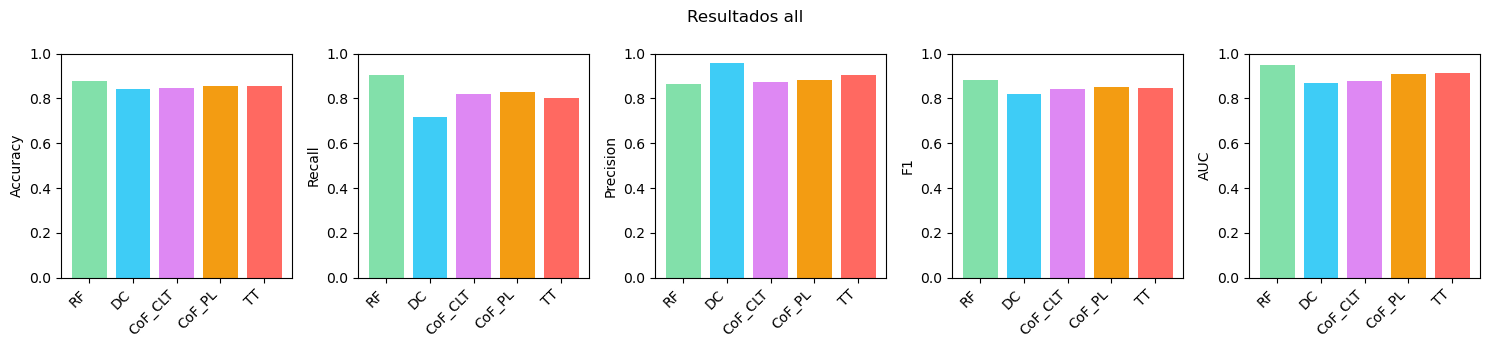

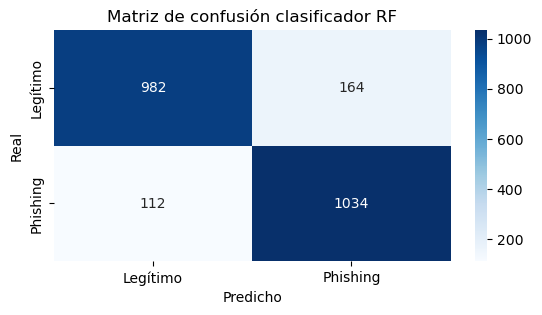

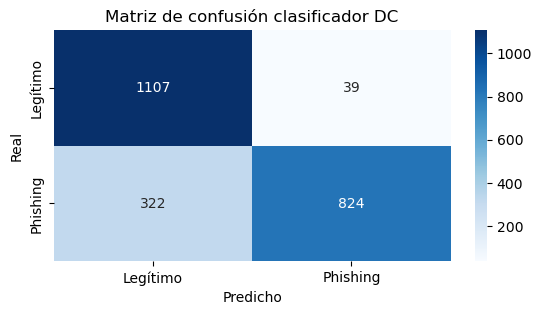

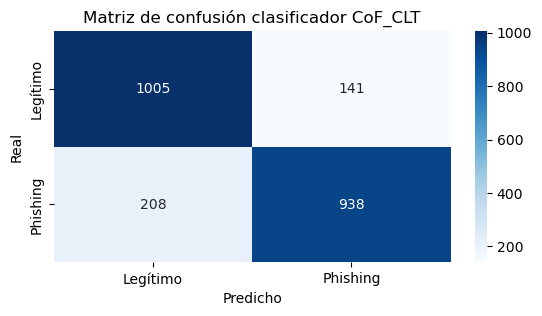

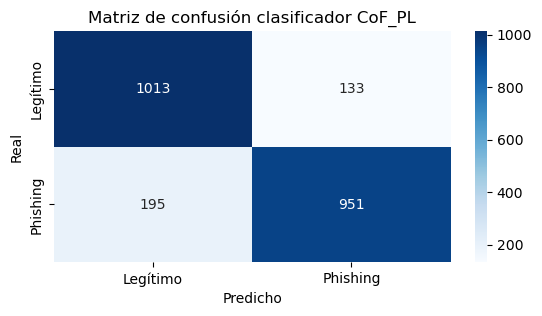

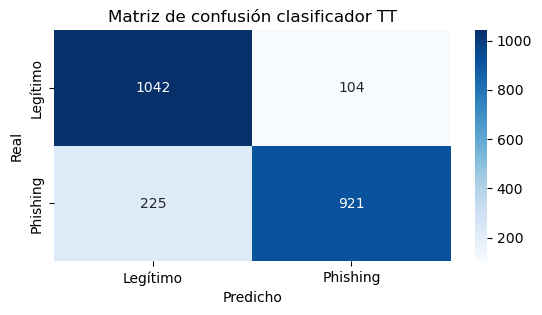

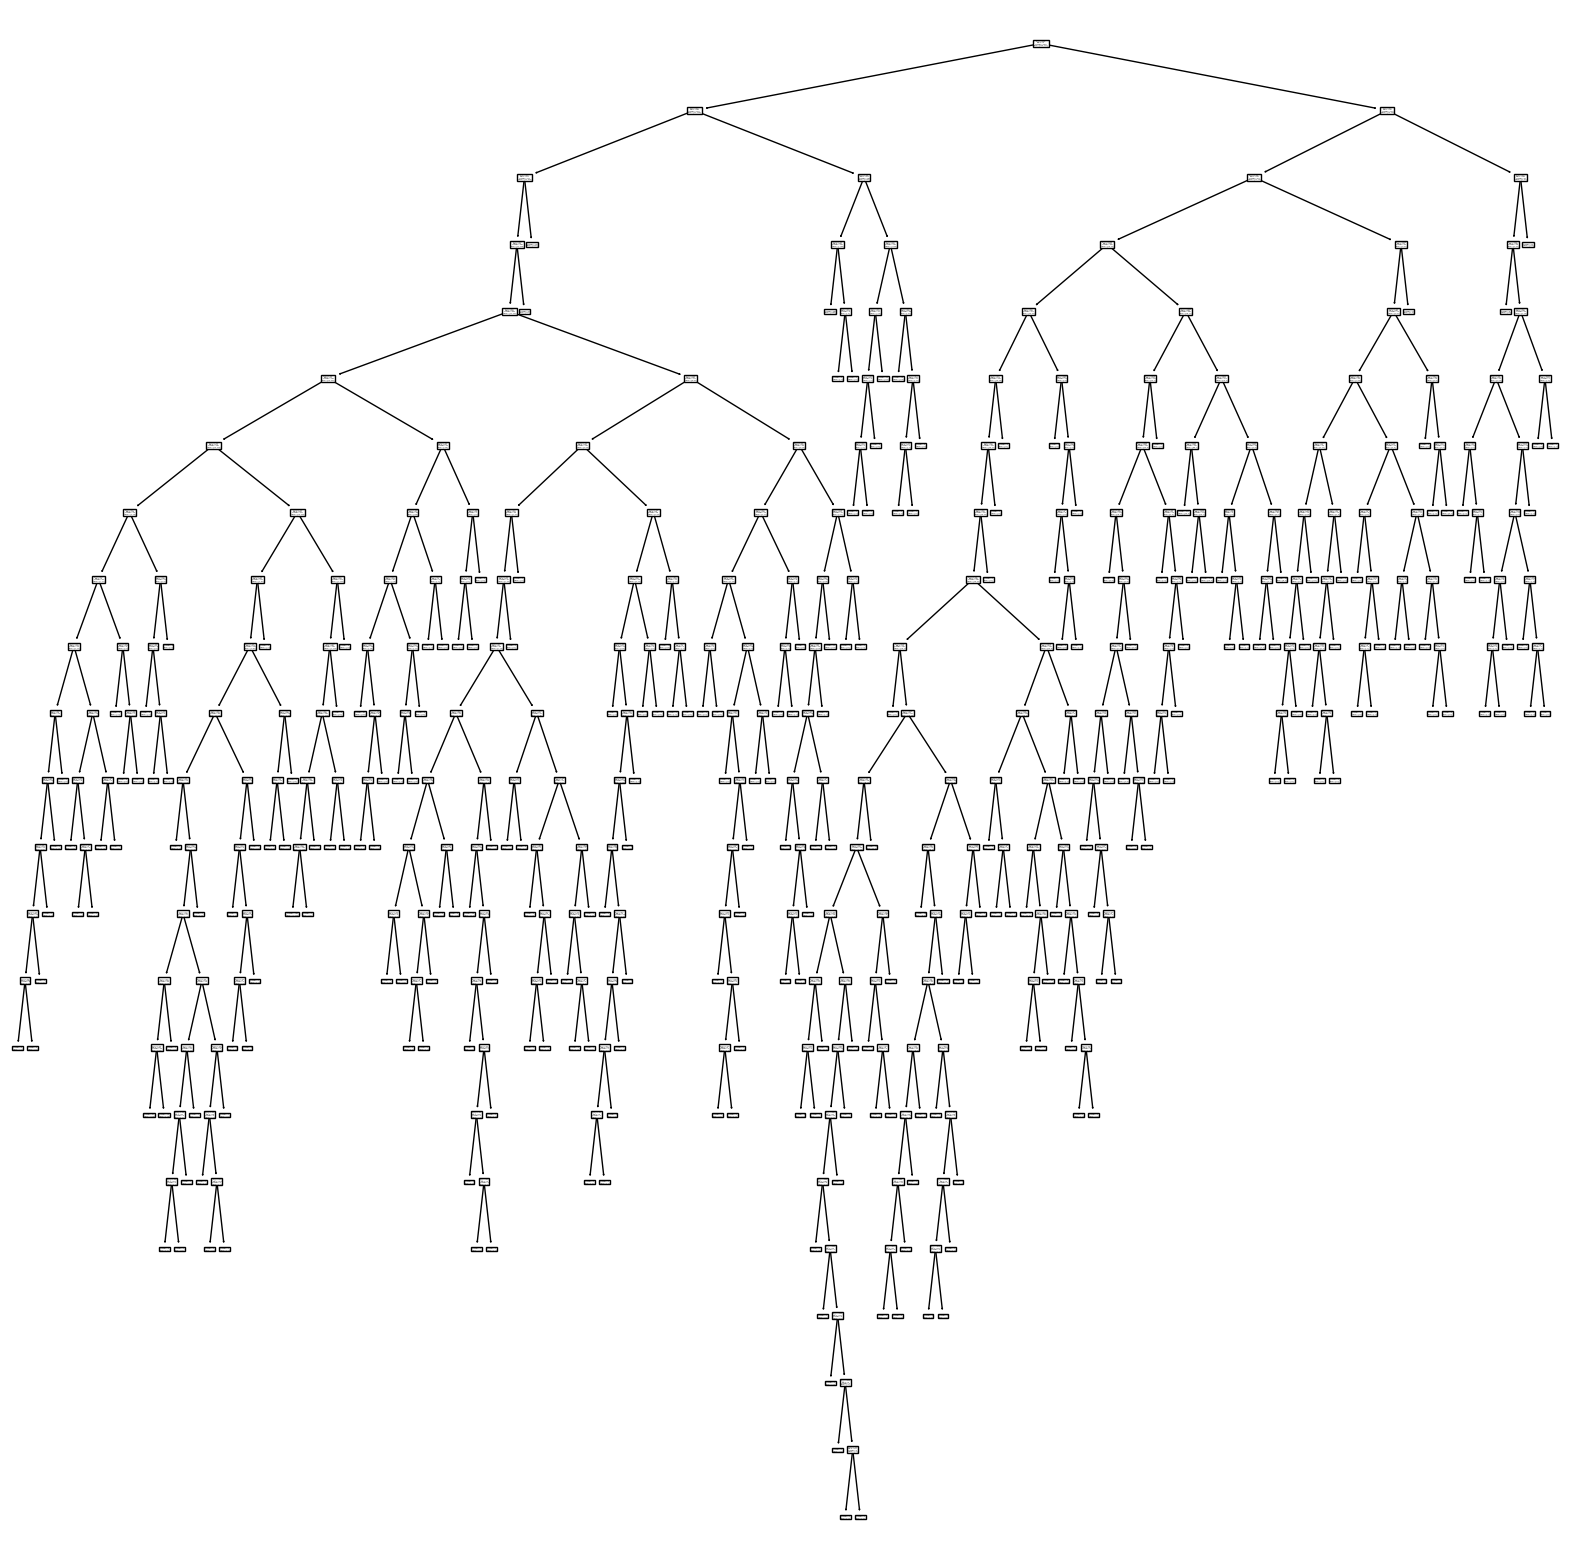

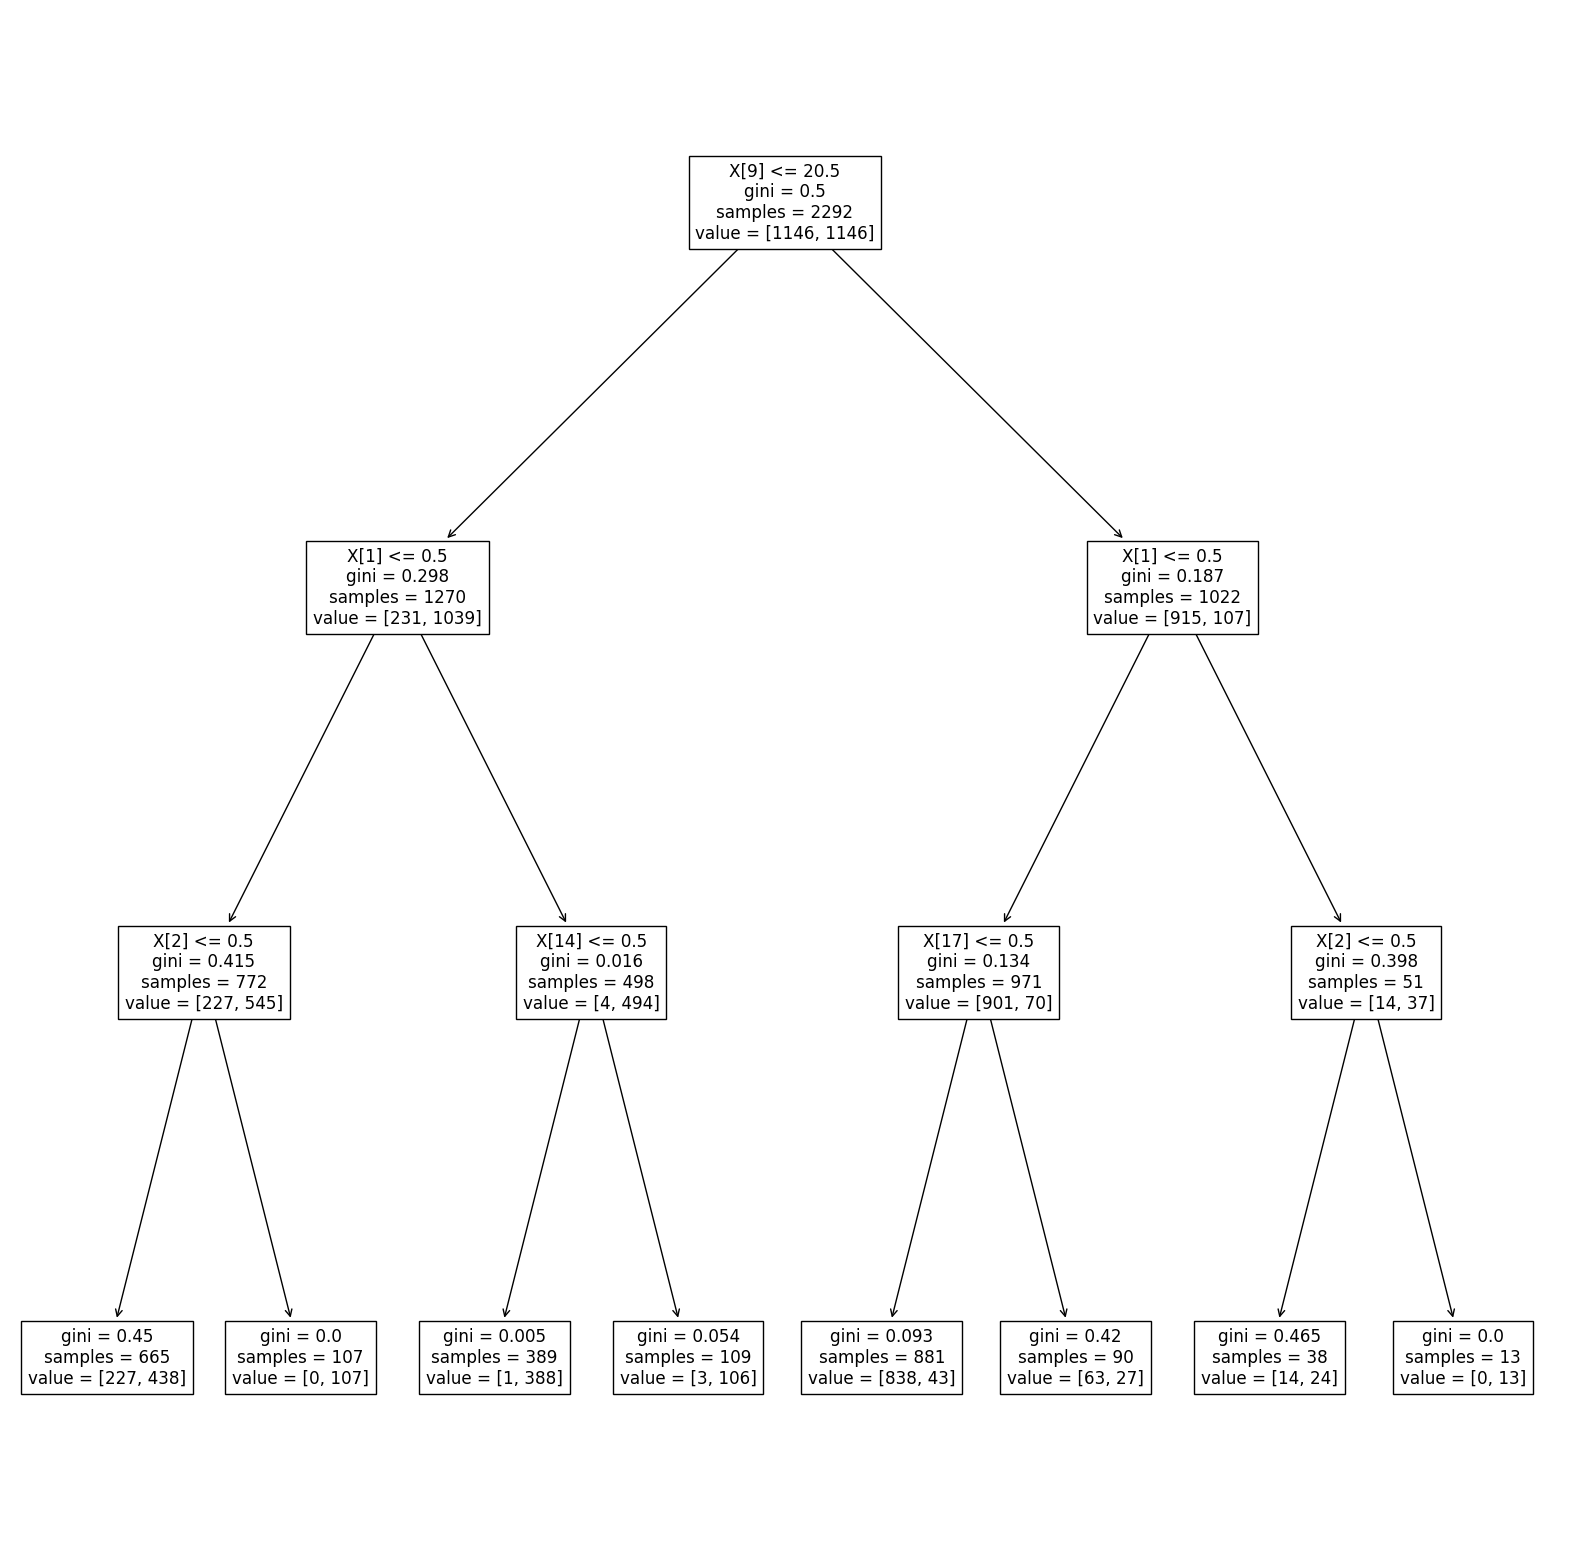

In [10]:
used_features = 'all'
run_all(used_features)

C:\Users\Patricia\AppData\Local\Temp\ipykernel_8028\3451954425.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(cls_names, rotation=45, ha="right")


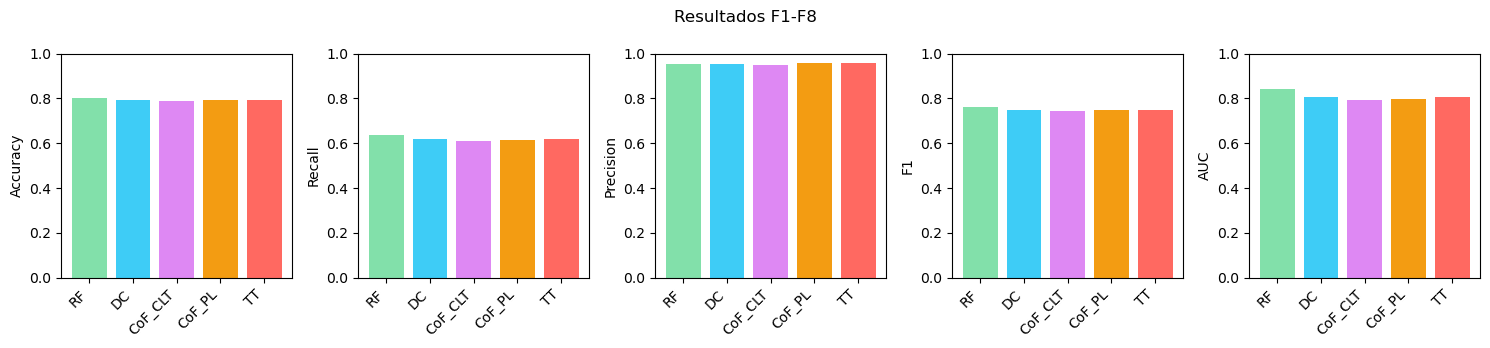

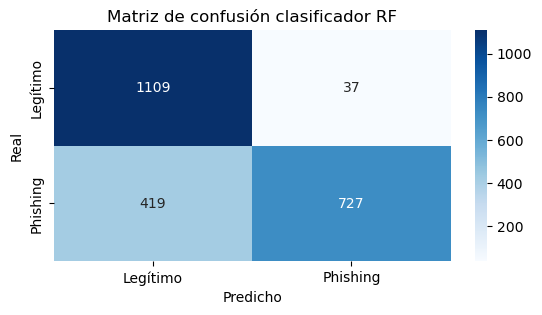

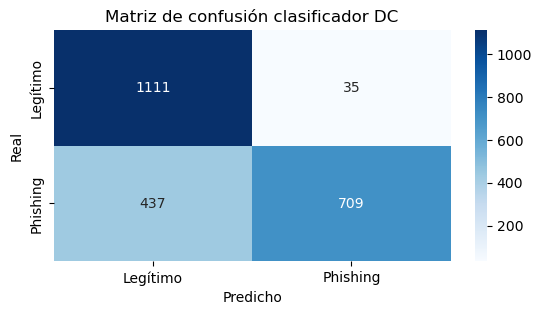

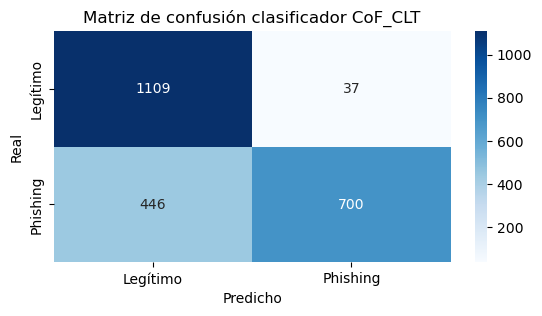

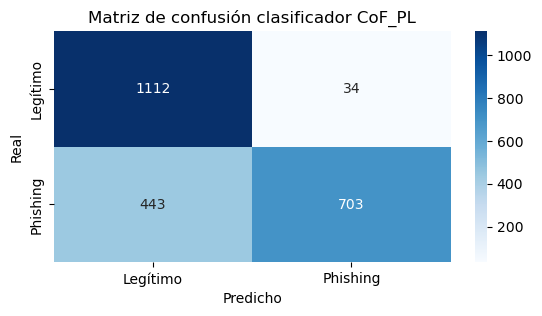

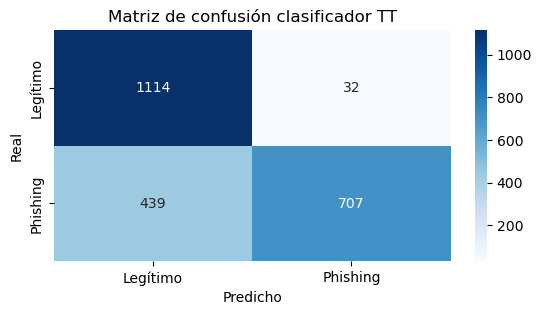

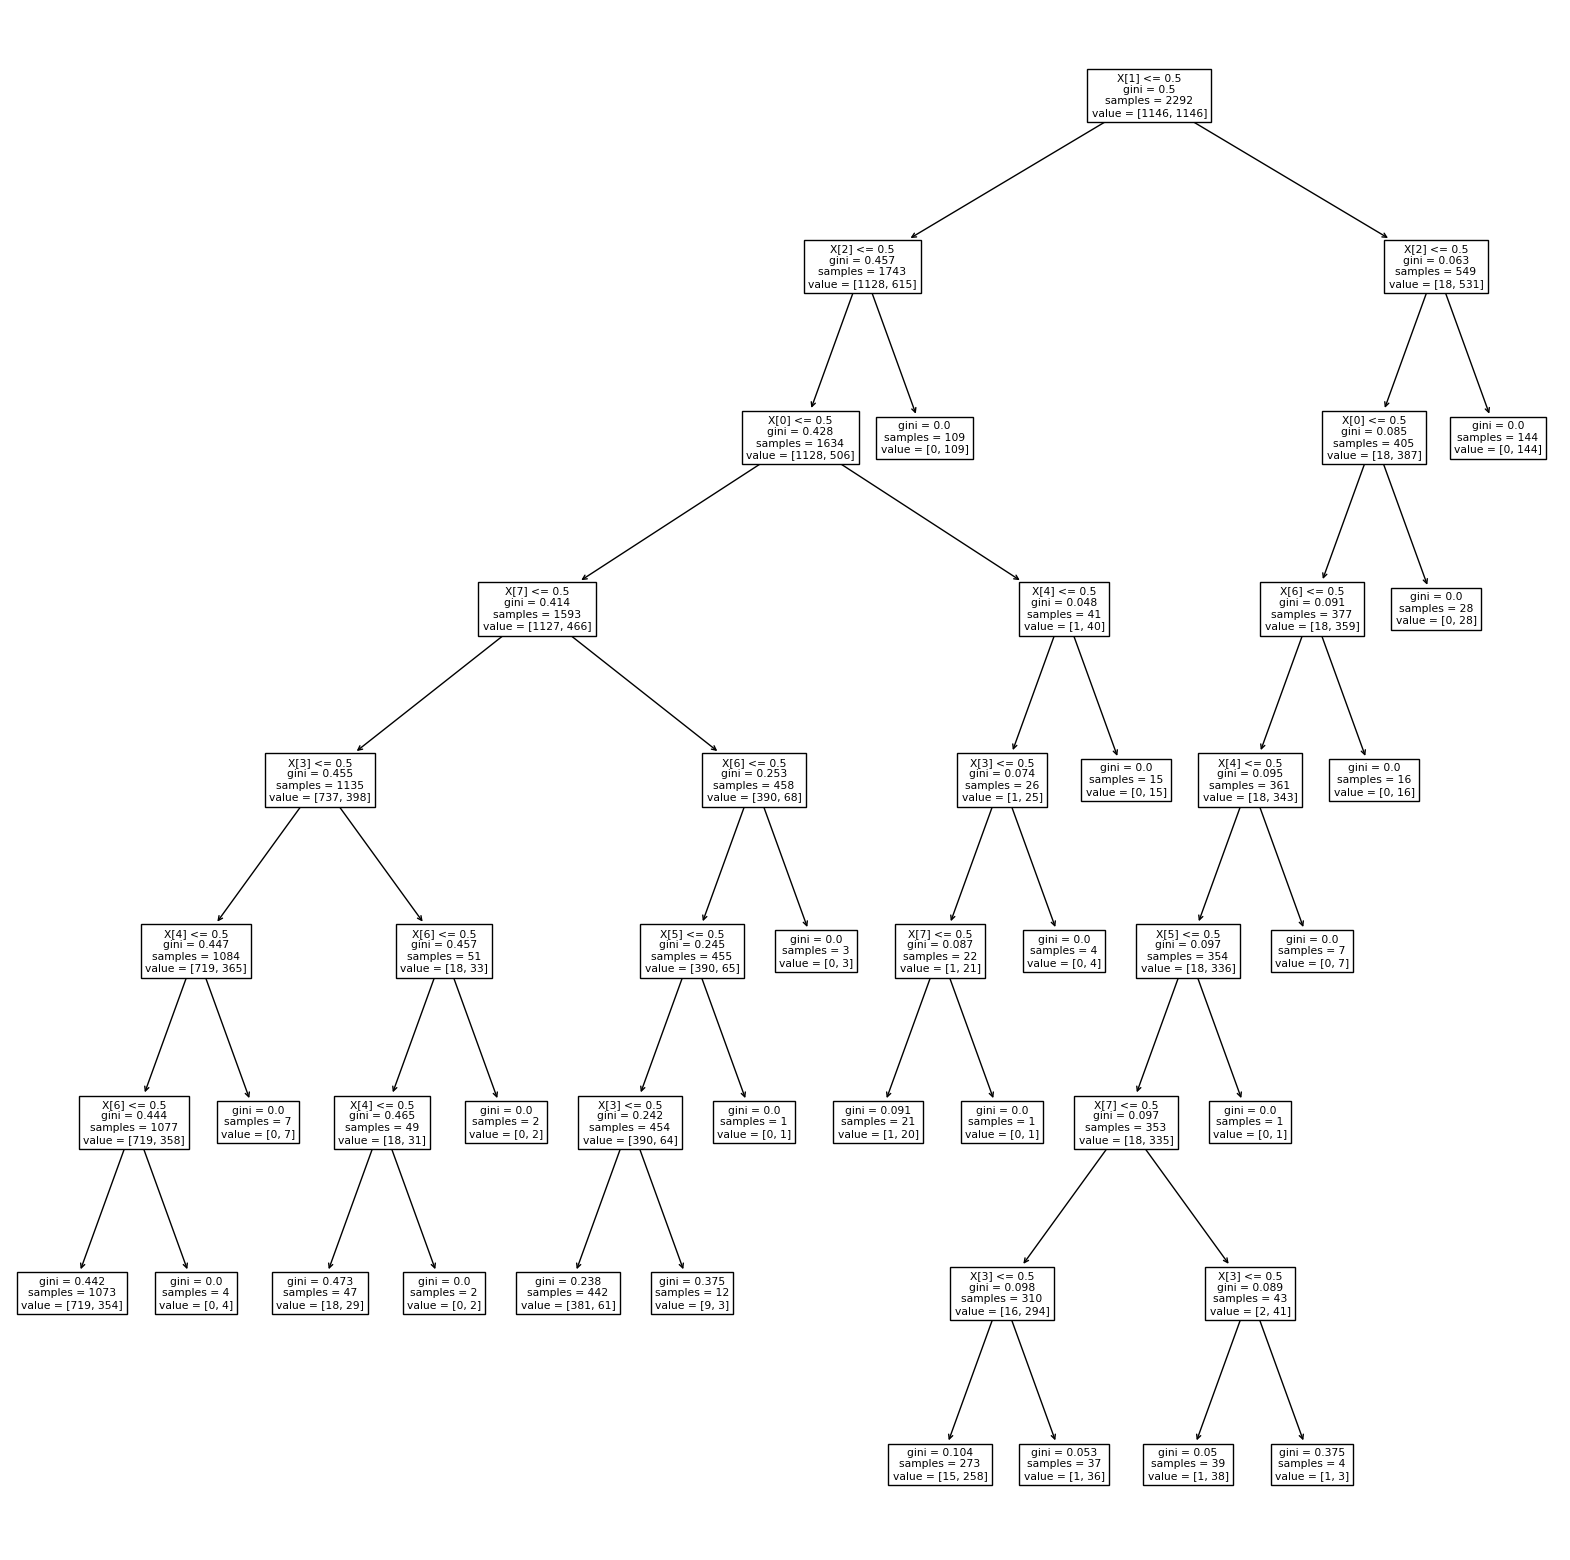

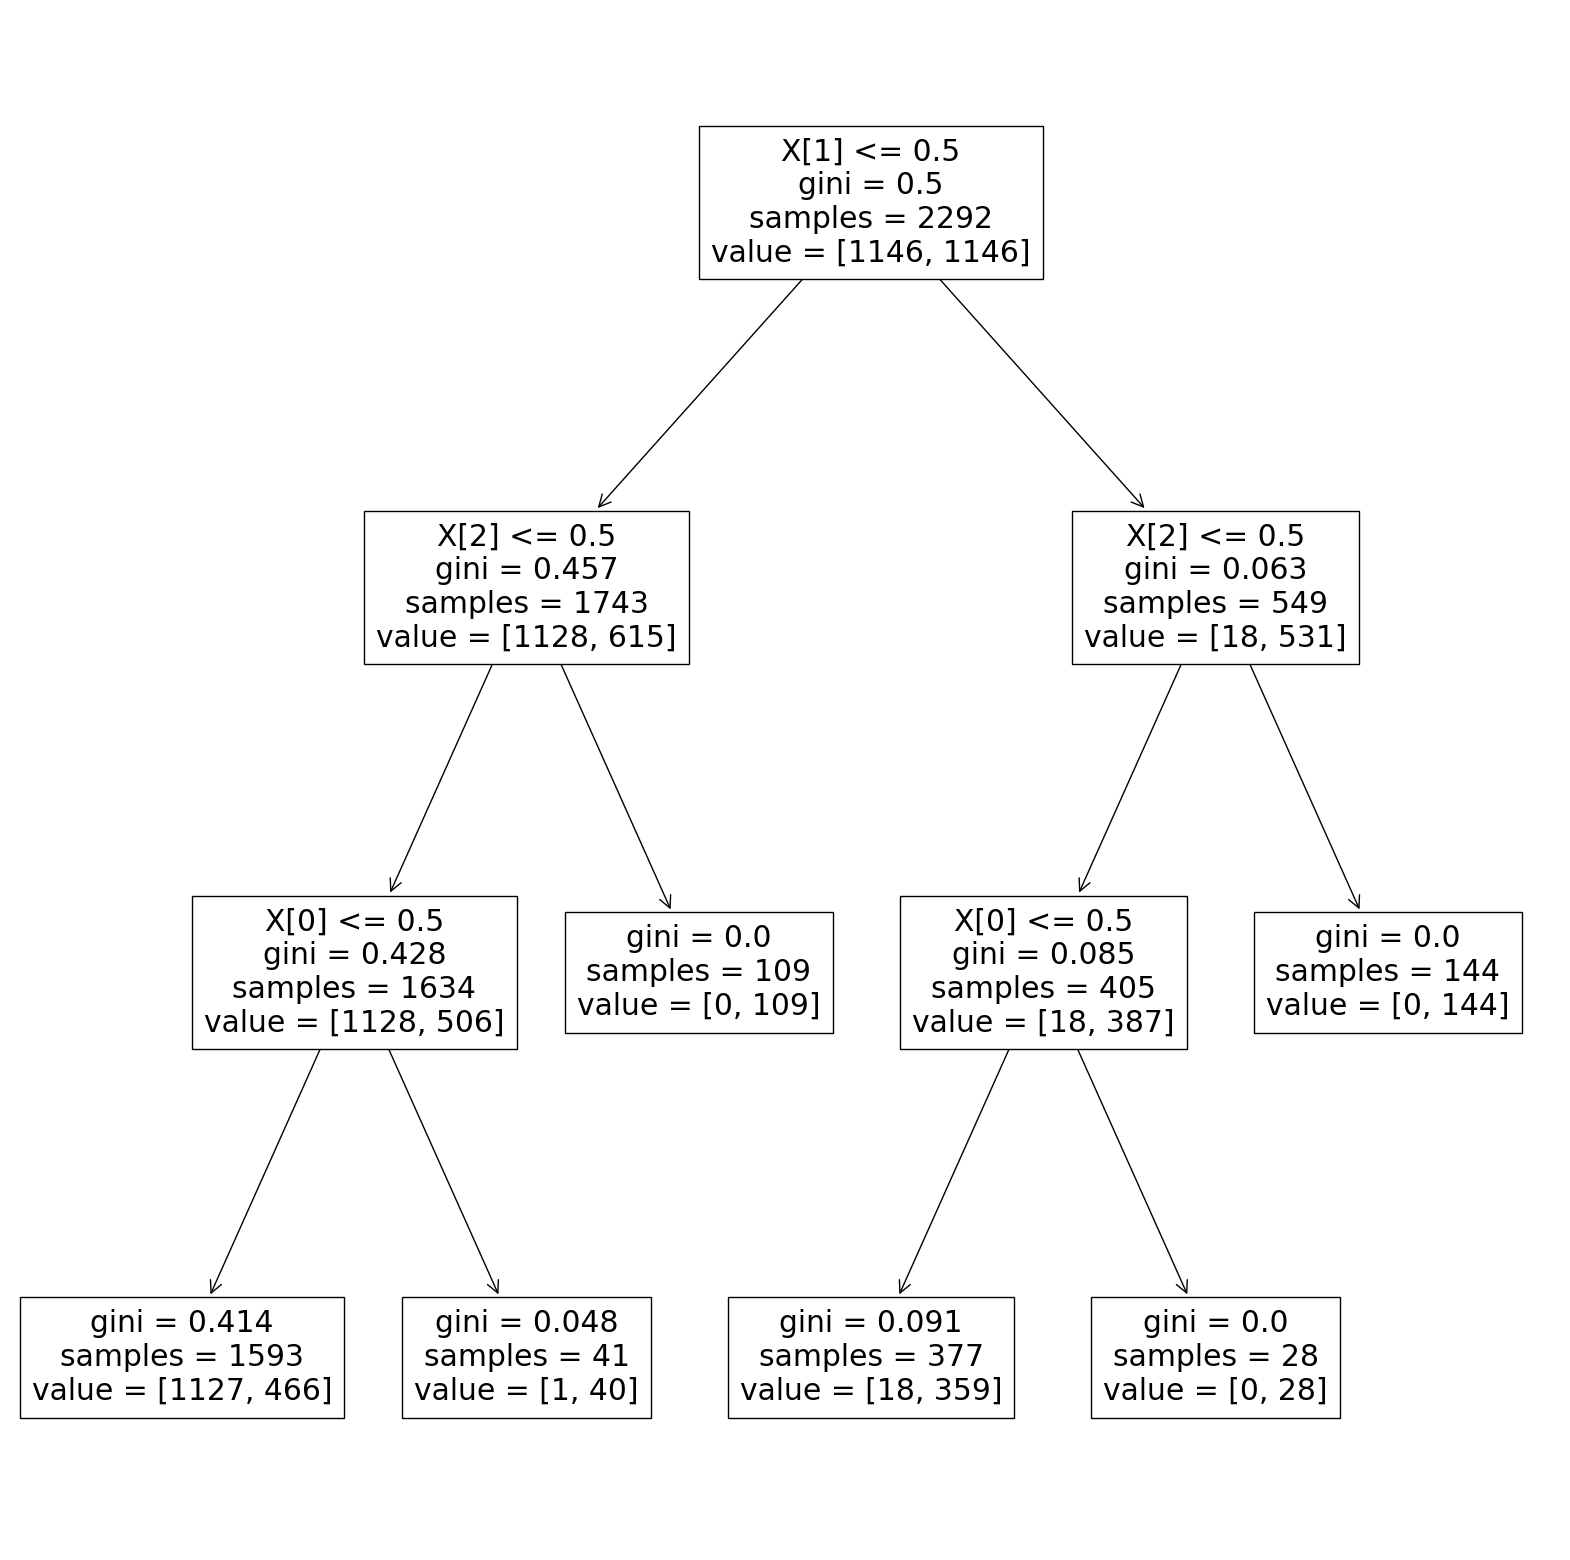

In [11]:
used_features = 'F1-F8'
run_all(used_features)

c:\Users\Patricia\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Patricia\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Patricia\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Patricia\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Patricia\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Patricia\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret

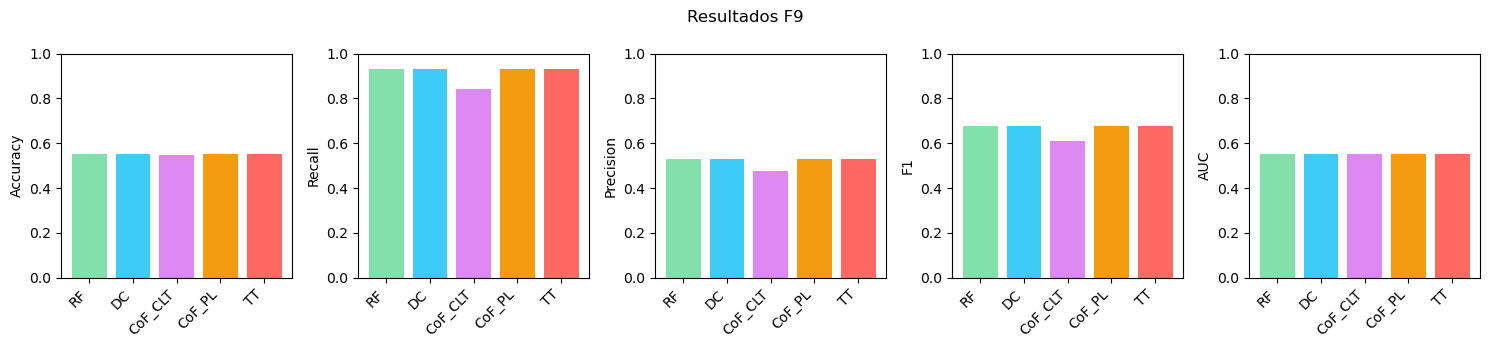

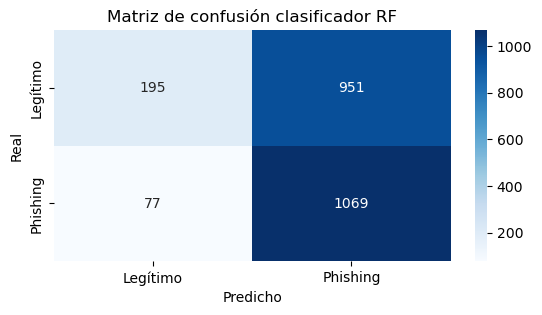

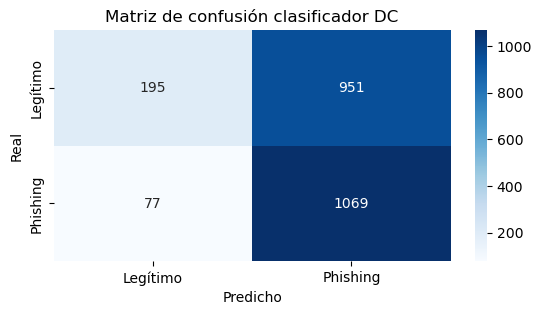

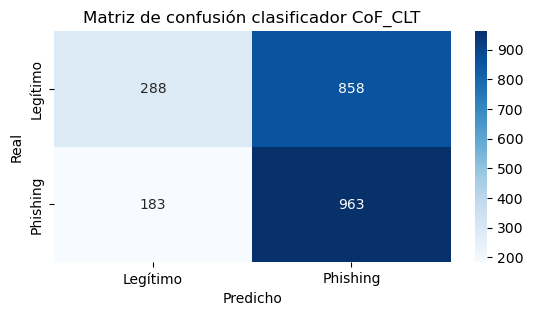

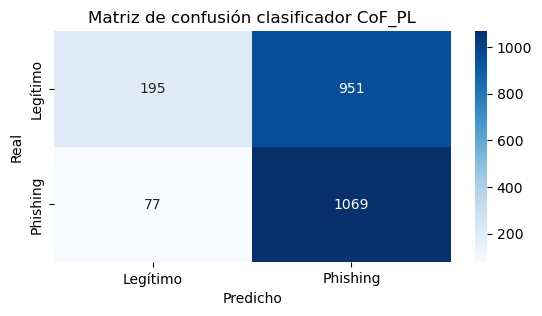

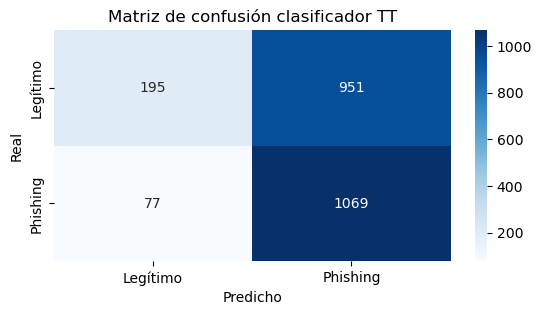

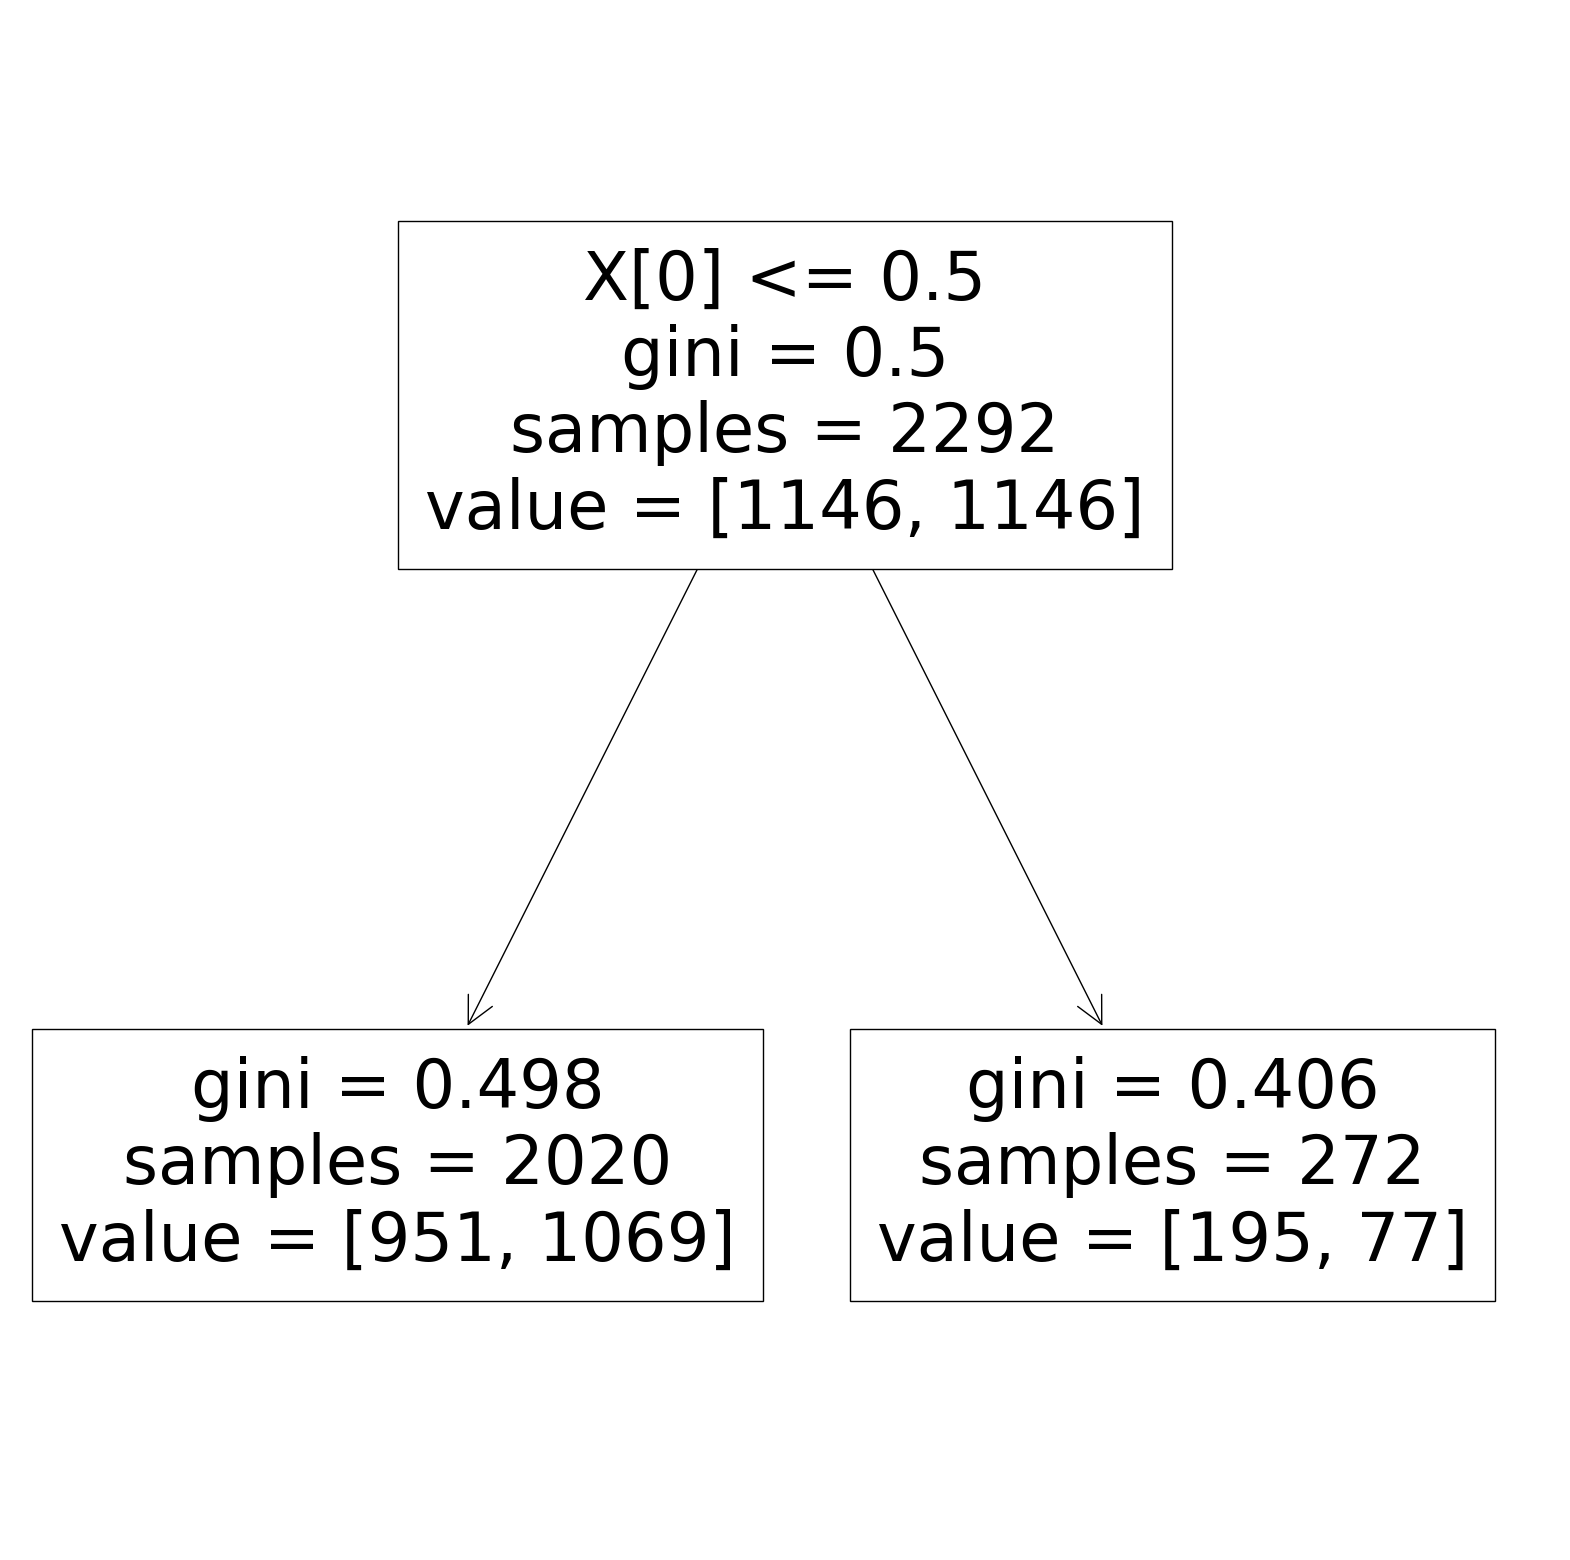

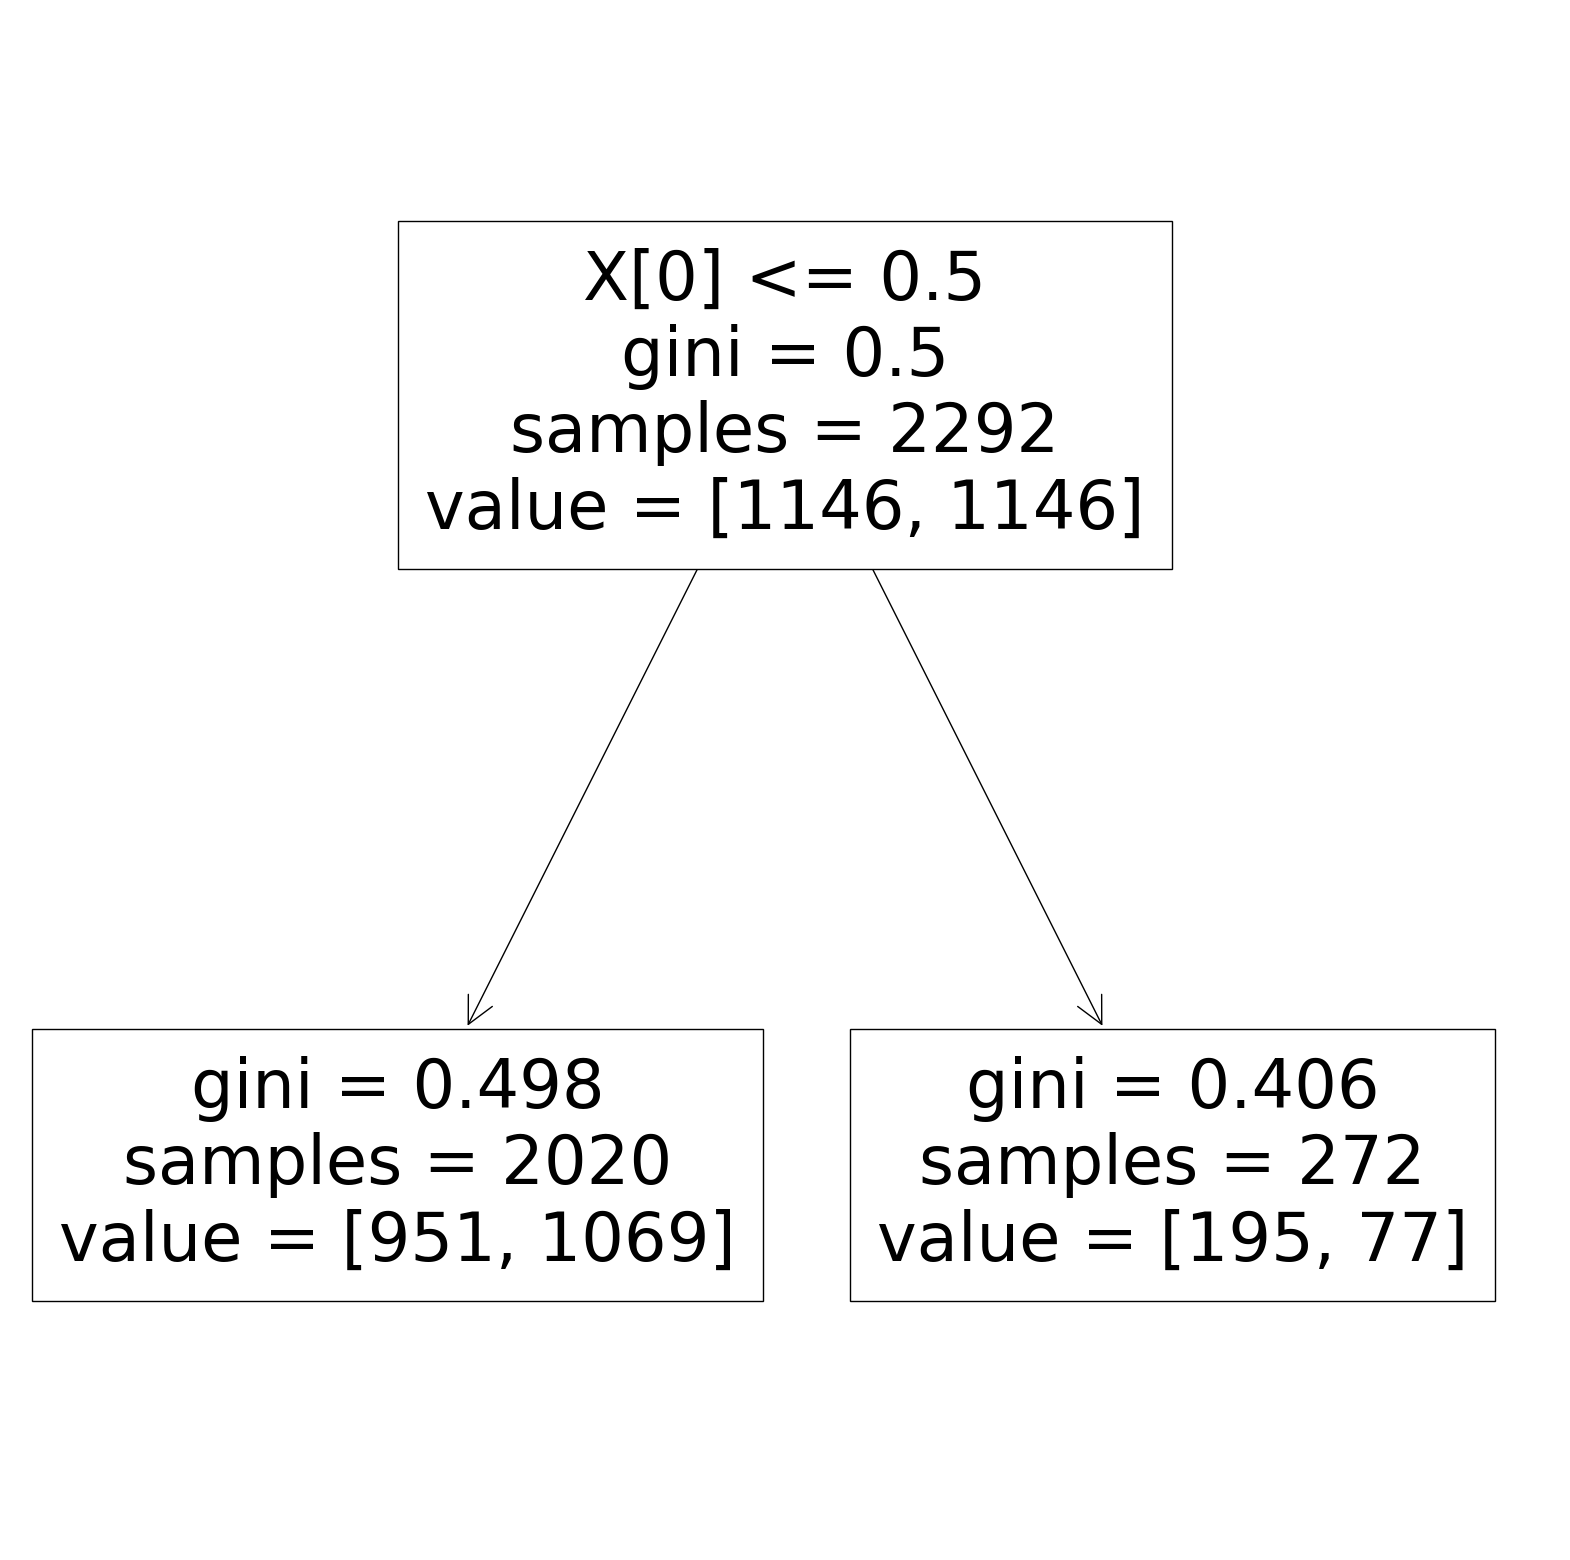

In [12]:
used_features = 'F9'
run_all(used_features)

C:\Users\Patricia\AppData\Local\Temp\ipykernel_8028\3451954425.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(cls_names, rotation=45, ha="right")


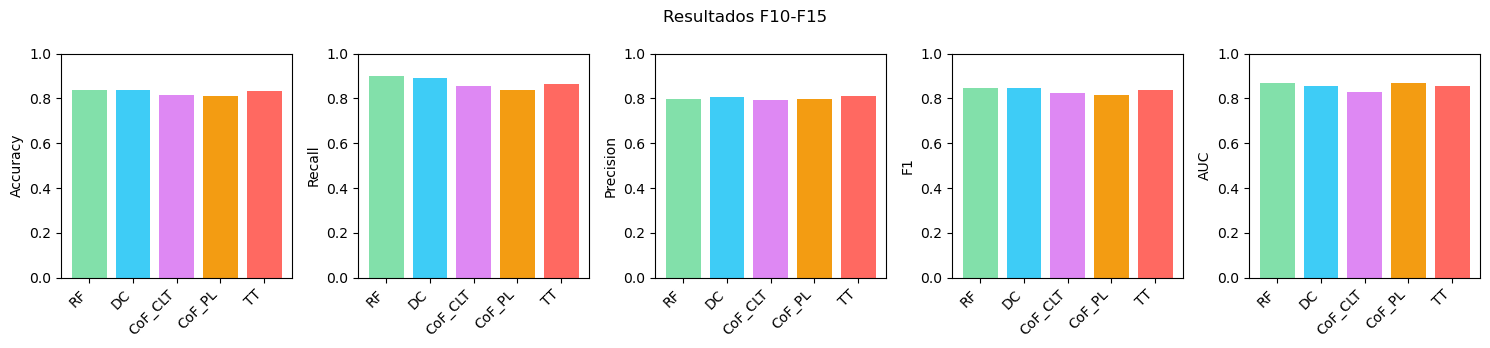

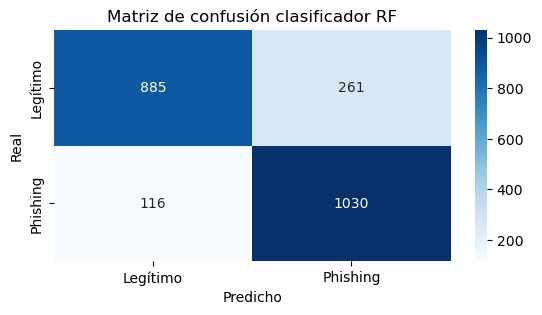

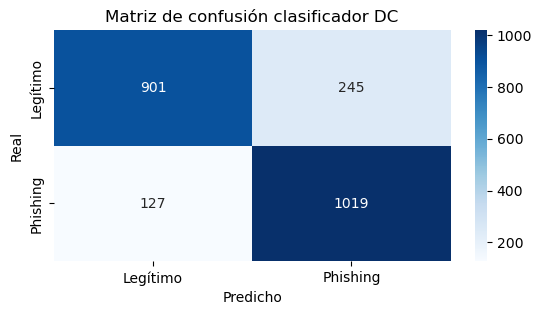

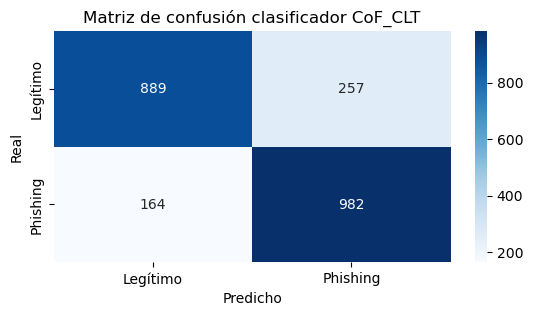

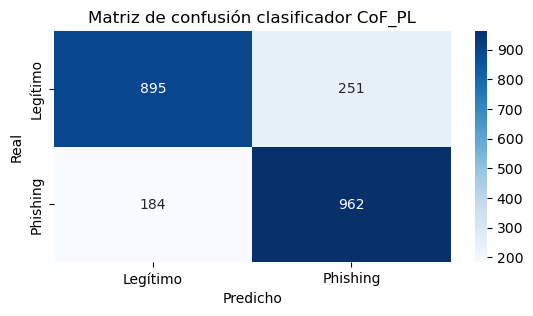

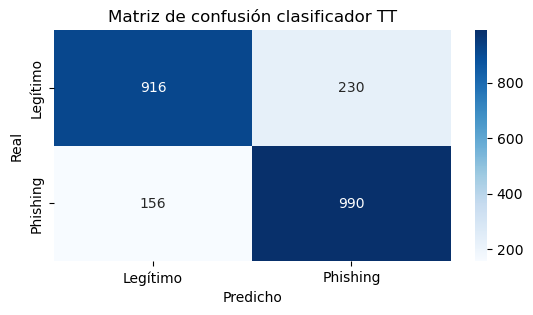

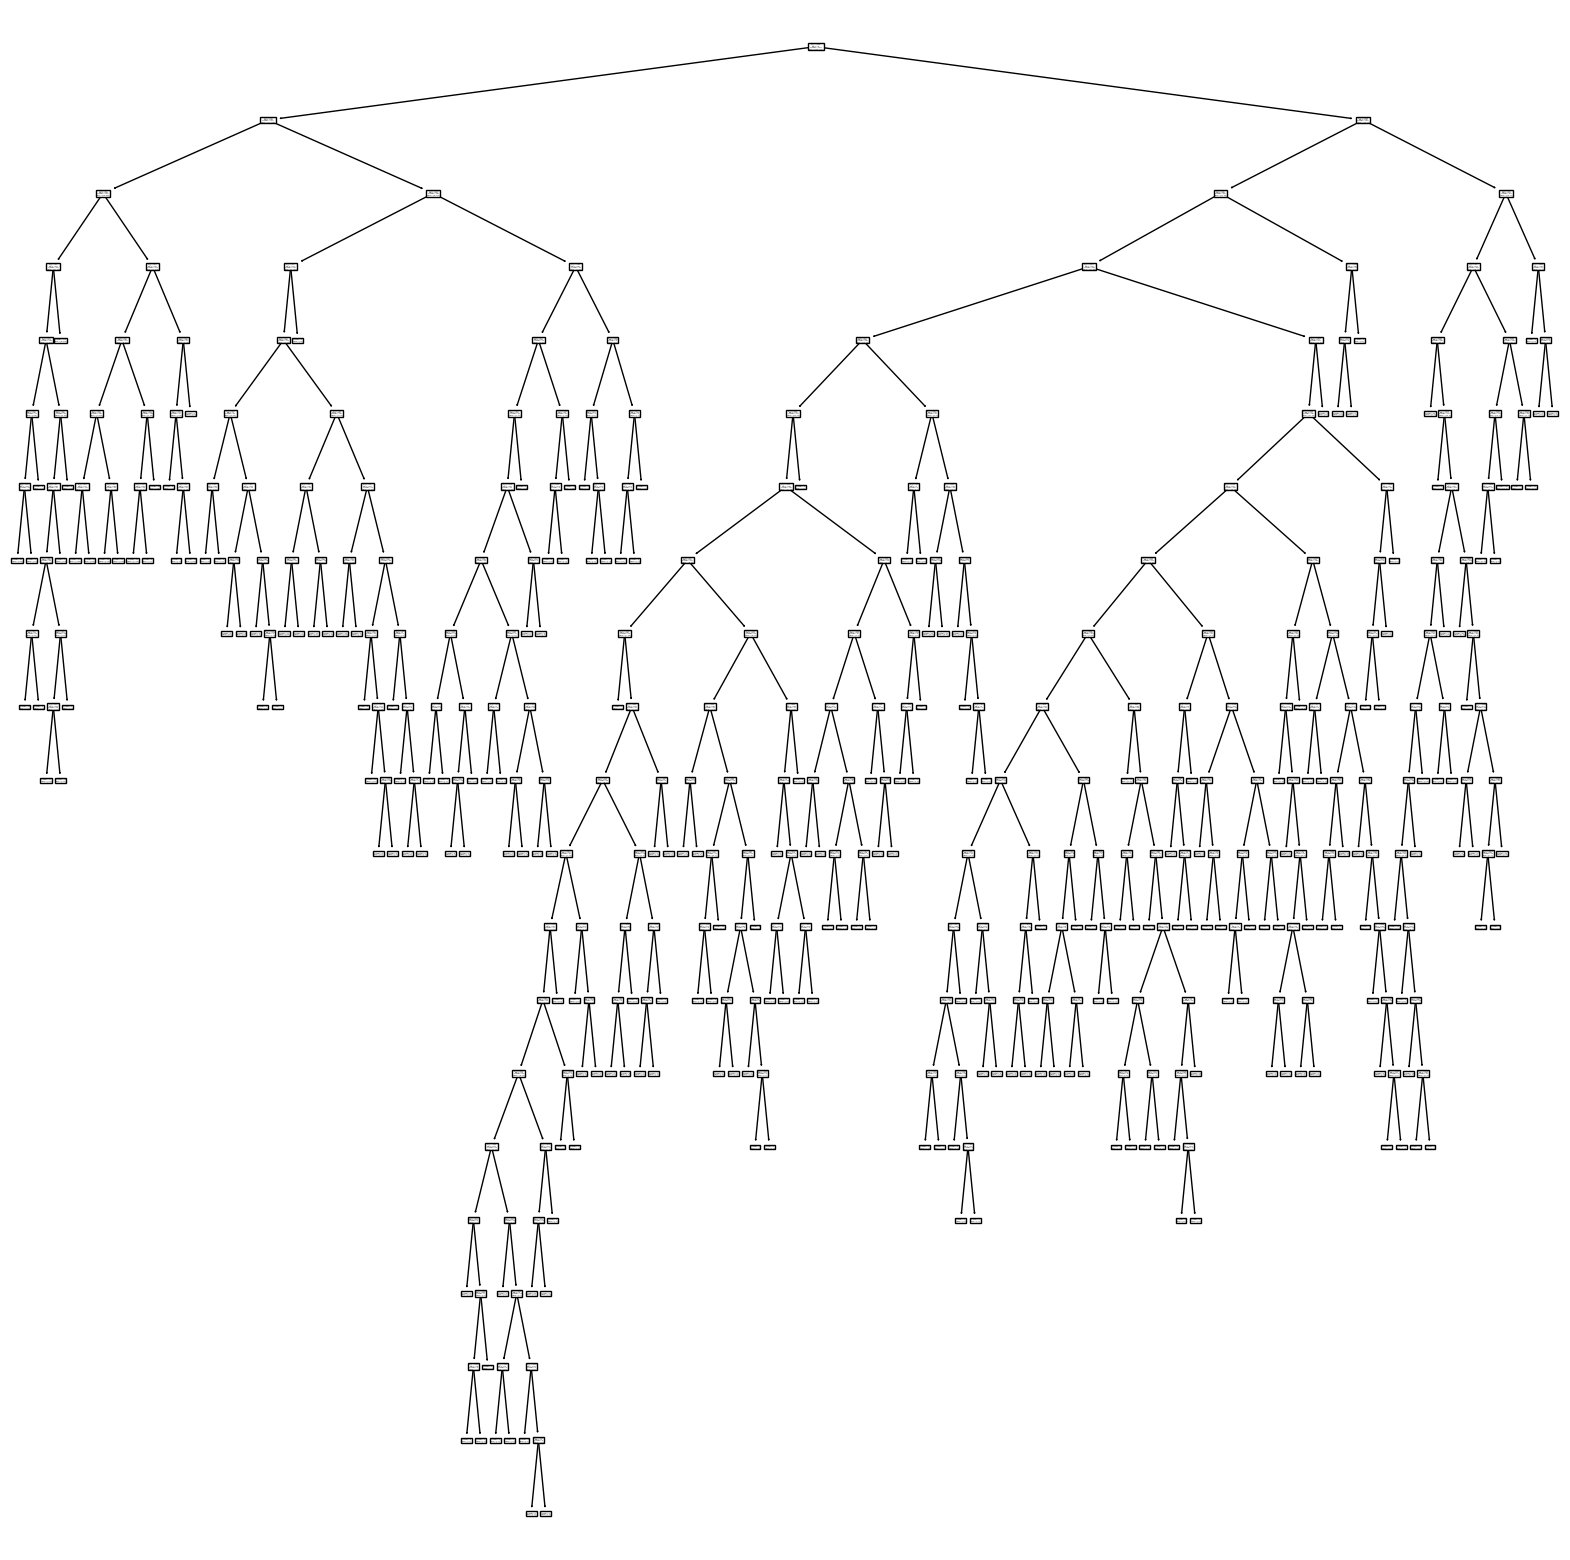

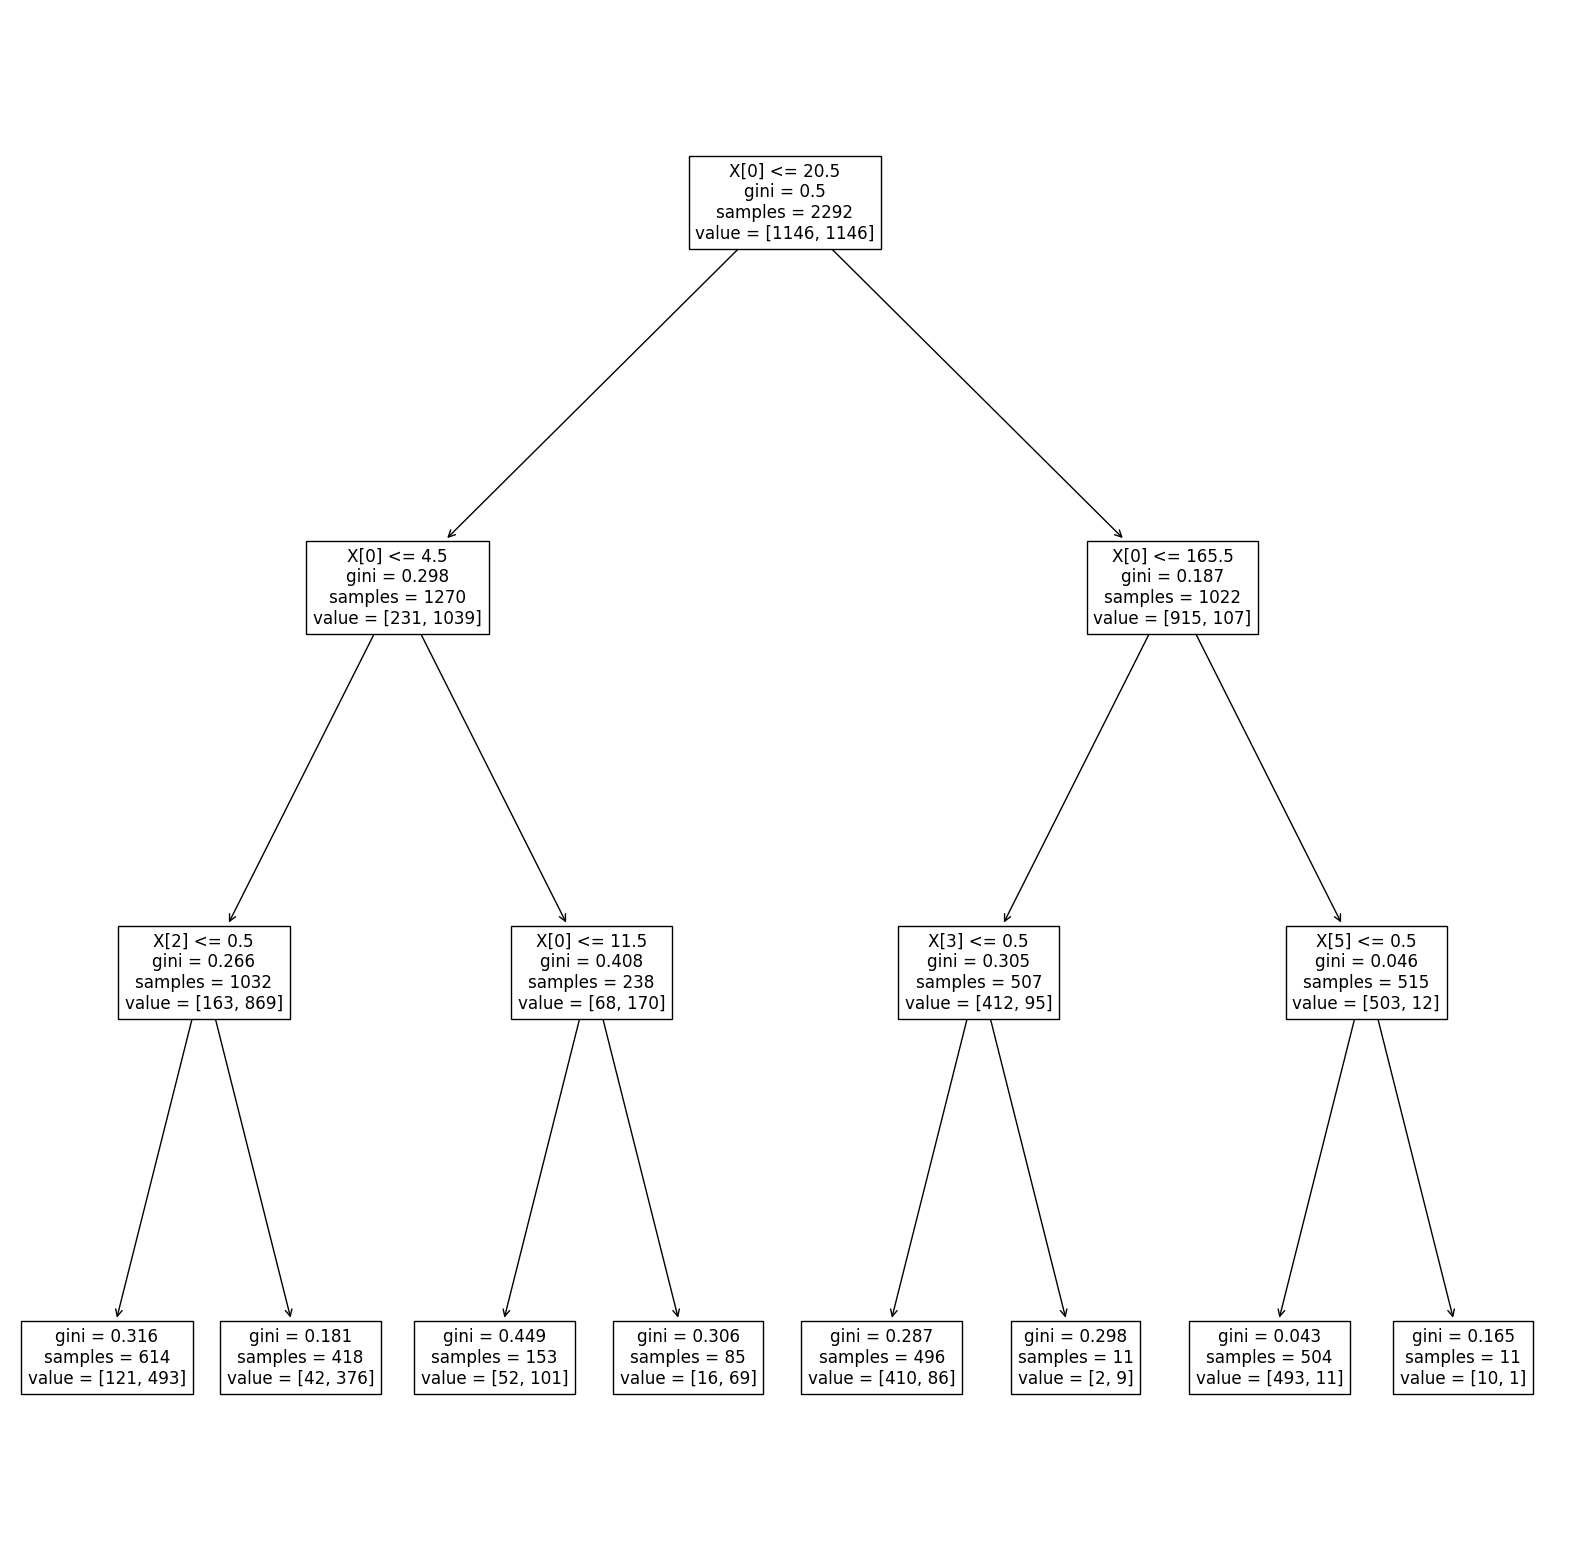

In [13]:
used_features = 'F10-F15'
run_all(used_features)

c:\Users\Patricia\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Patricia\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Patricia\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Patricia\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Patricia\source\repos\semisupervised-learning-in-cibersecurity\src\models\classifiers\TriTrainingClassifier.py:161: RuntimeWarning: invalid value encountered in long_scalars
  return sum(incorrect_classification) / sum(concordance)
c:\Users\Patricia\source\repos\semisupervised-learning-in-cibersecurity\src\models\cl

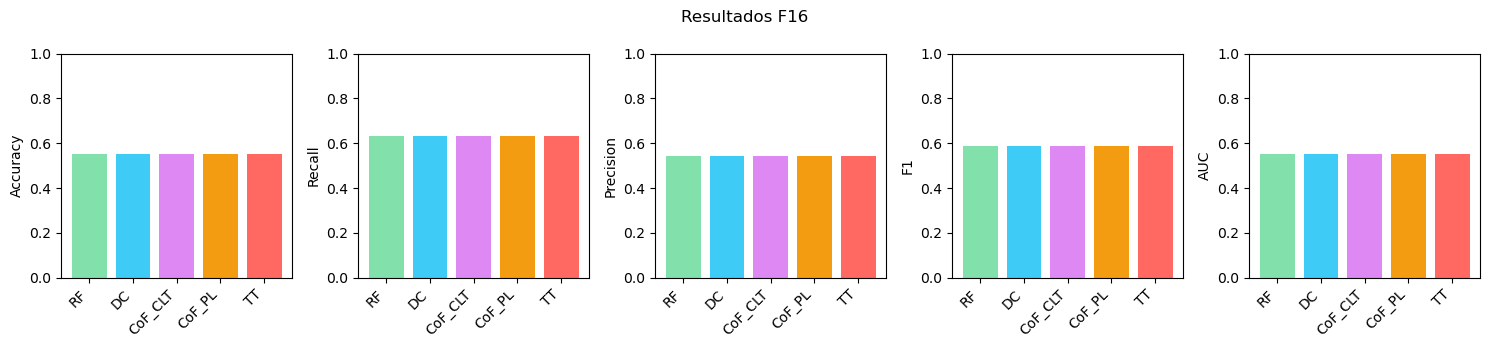

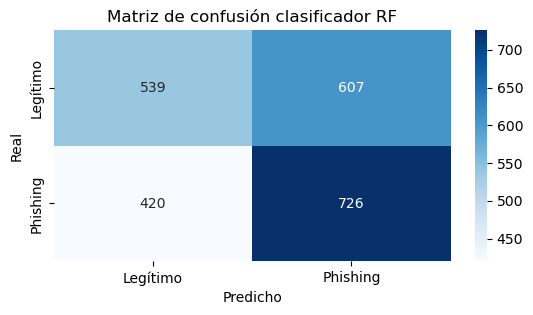

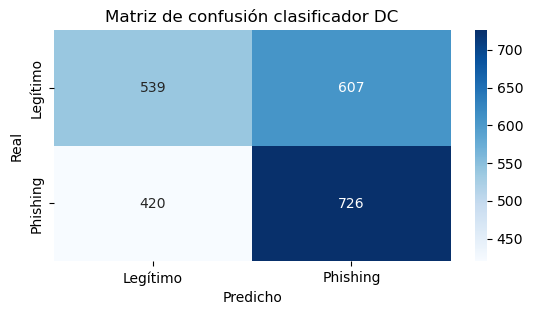

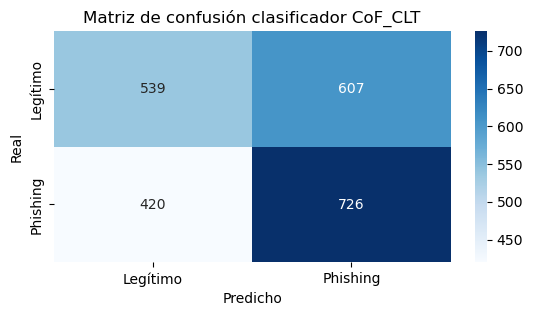

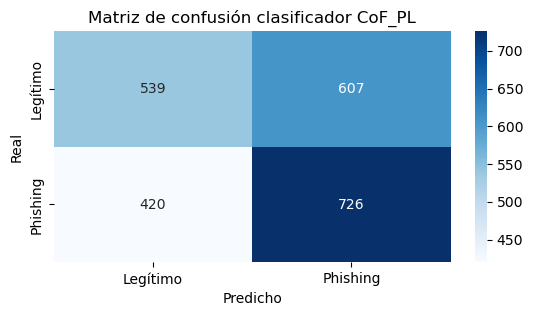

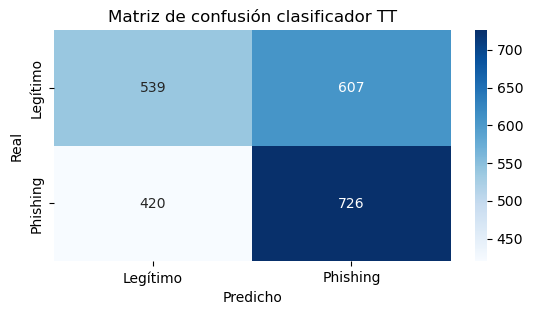

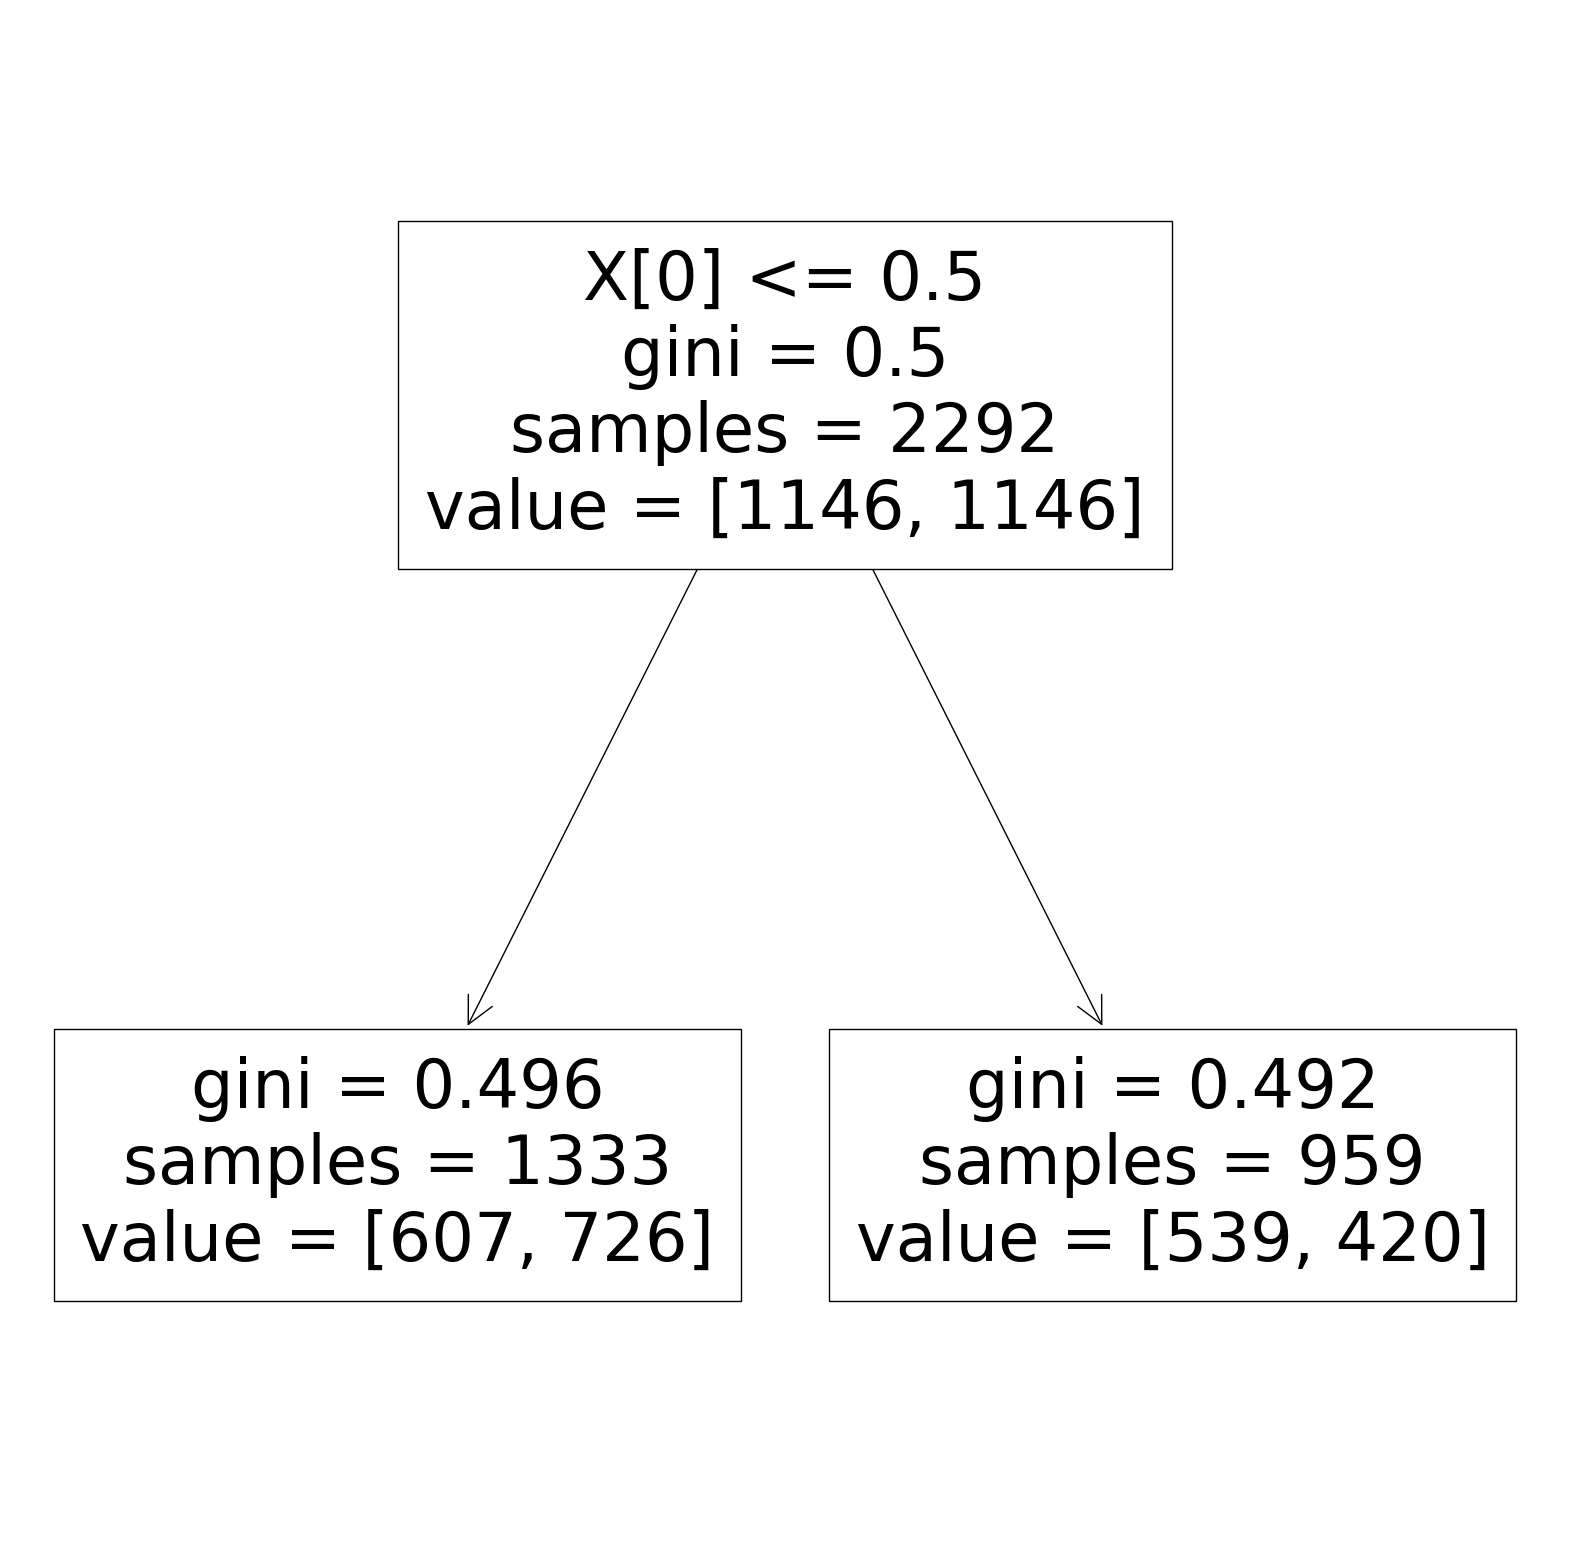

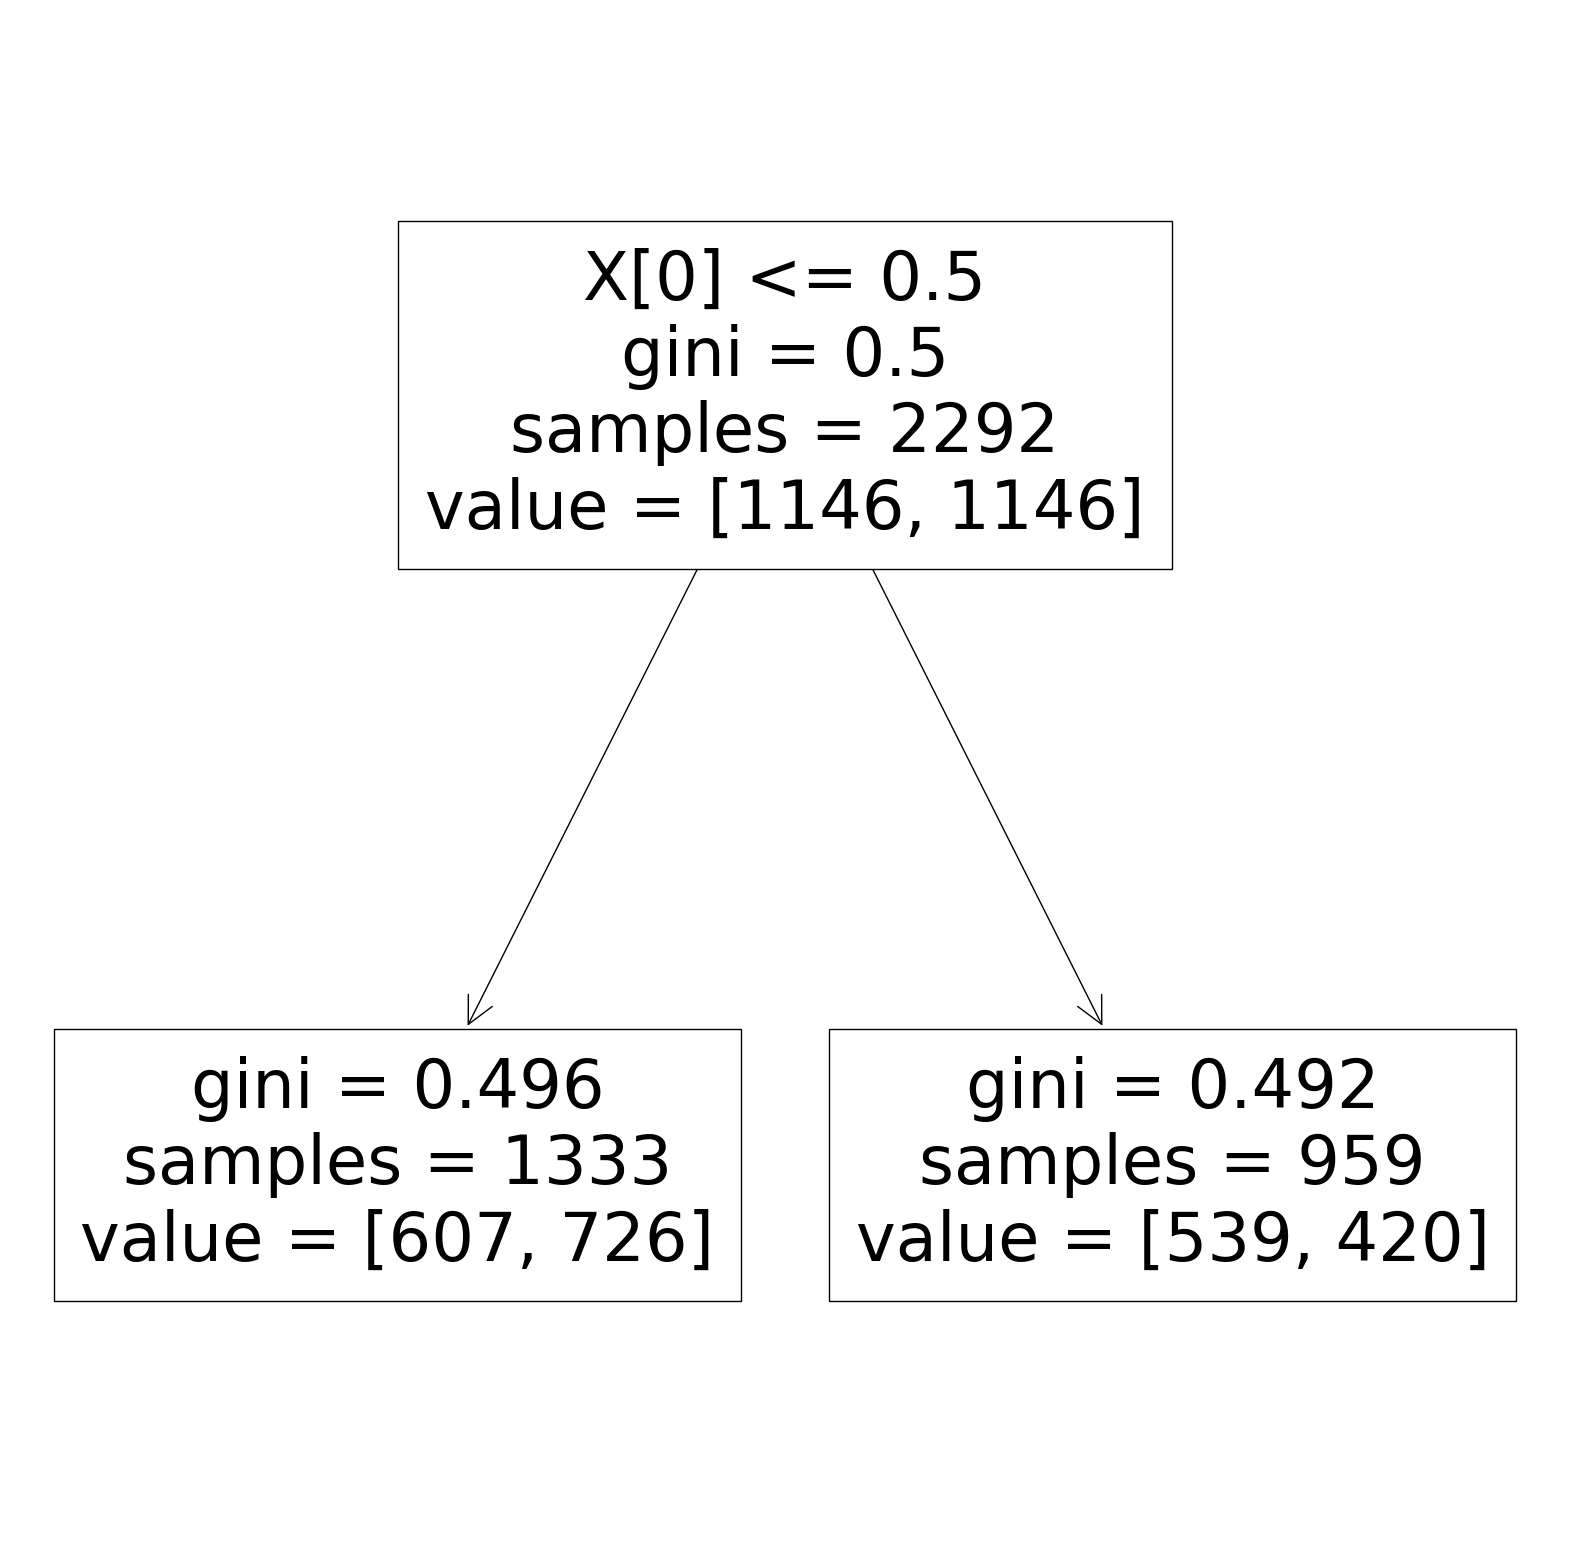

In [14]:
used_features = 'F16'
run_all(used_features)

c:\Users\Patricia\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Patricia\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Patricia\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Patricia\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Patricia\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Patricia\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret

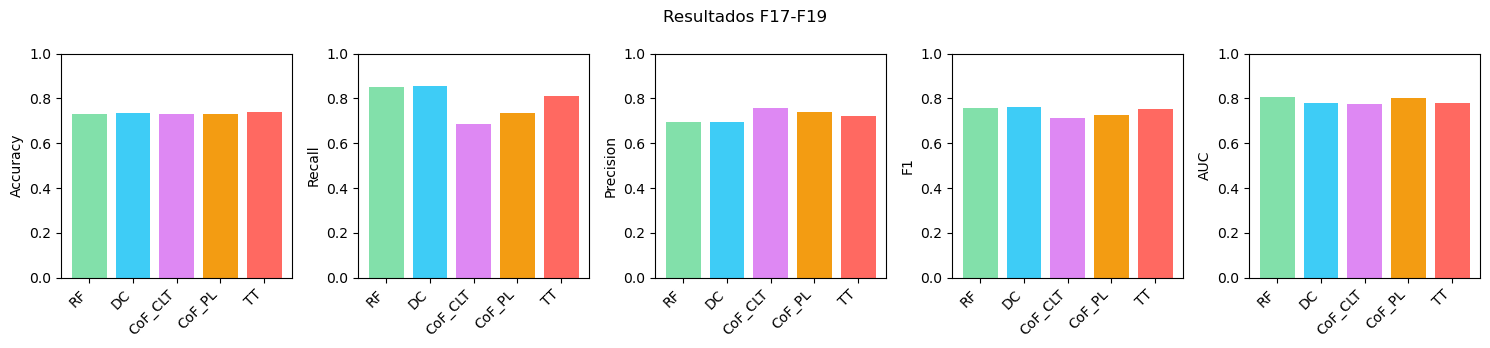

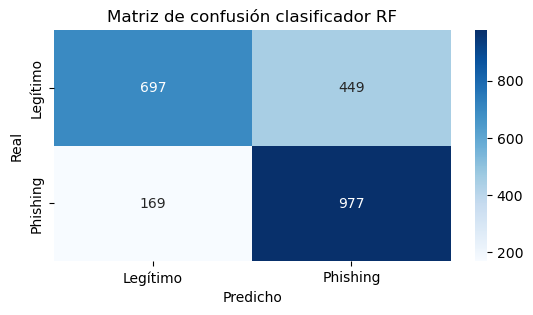

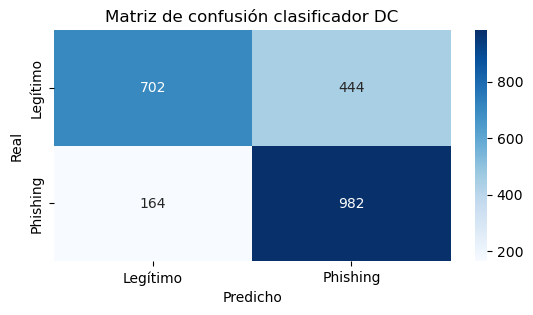

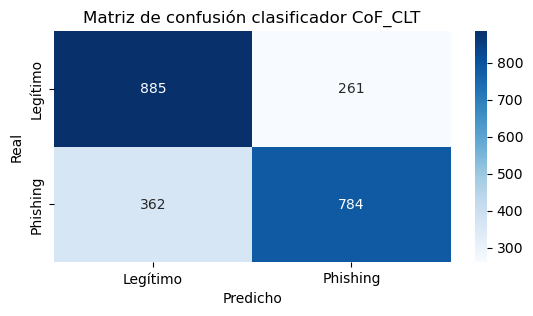

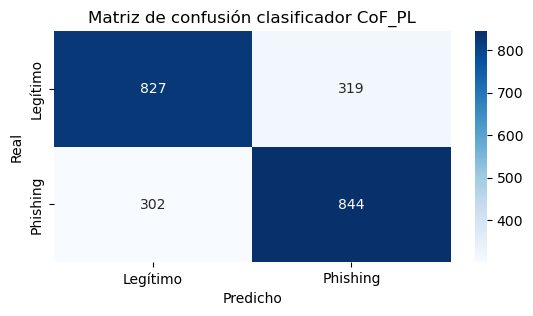

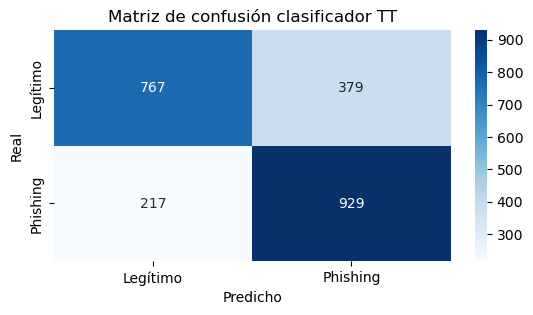

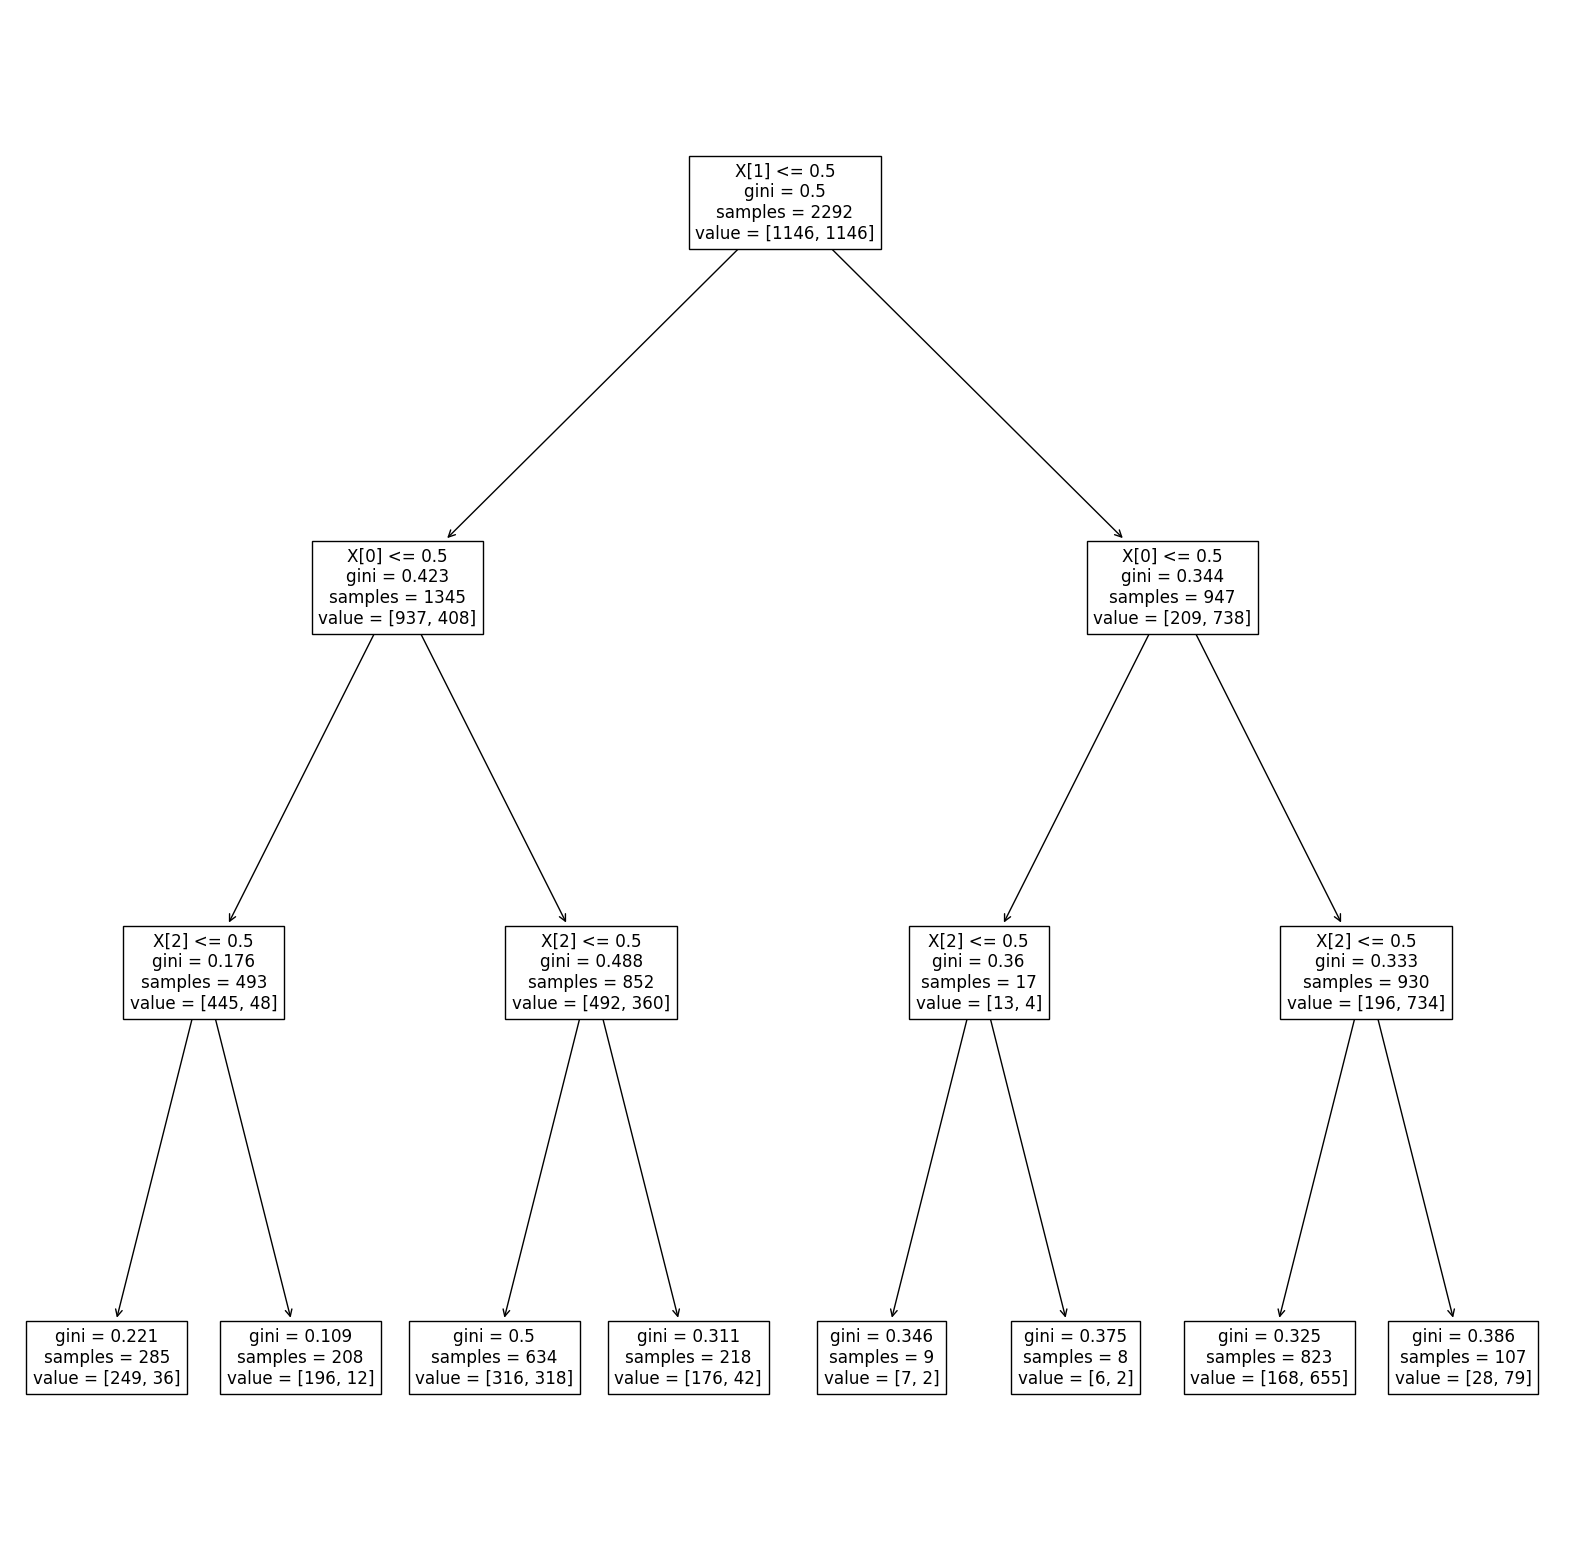

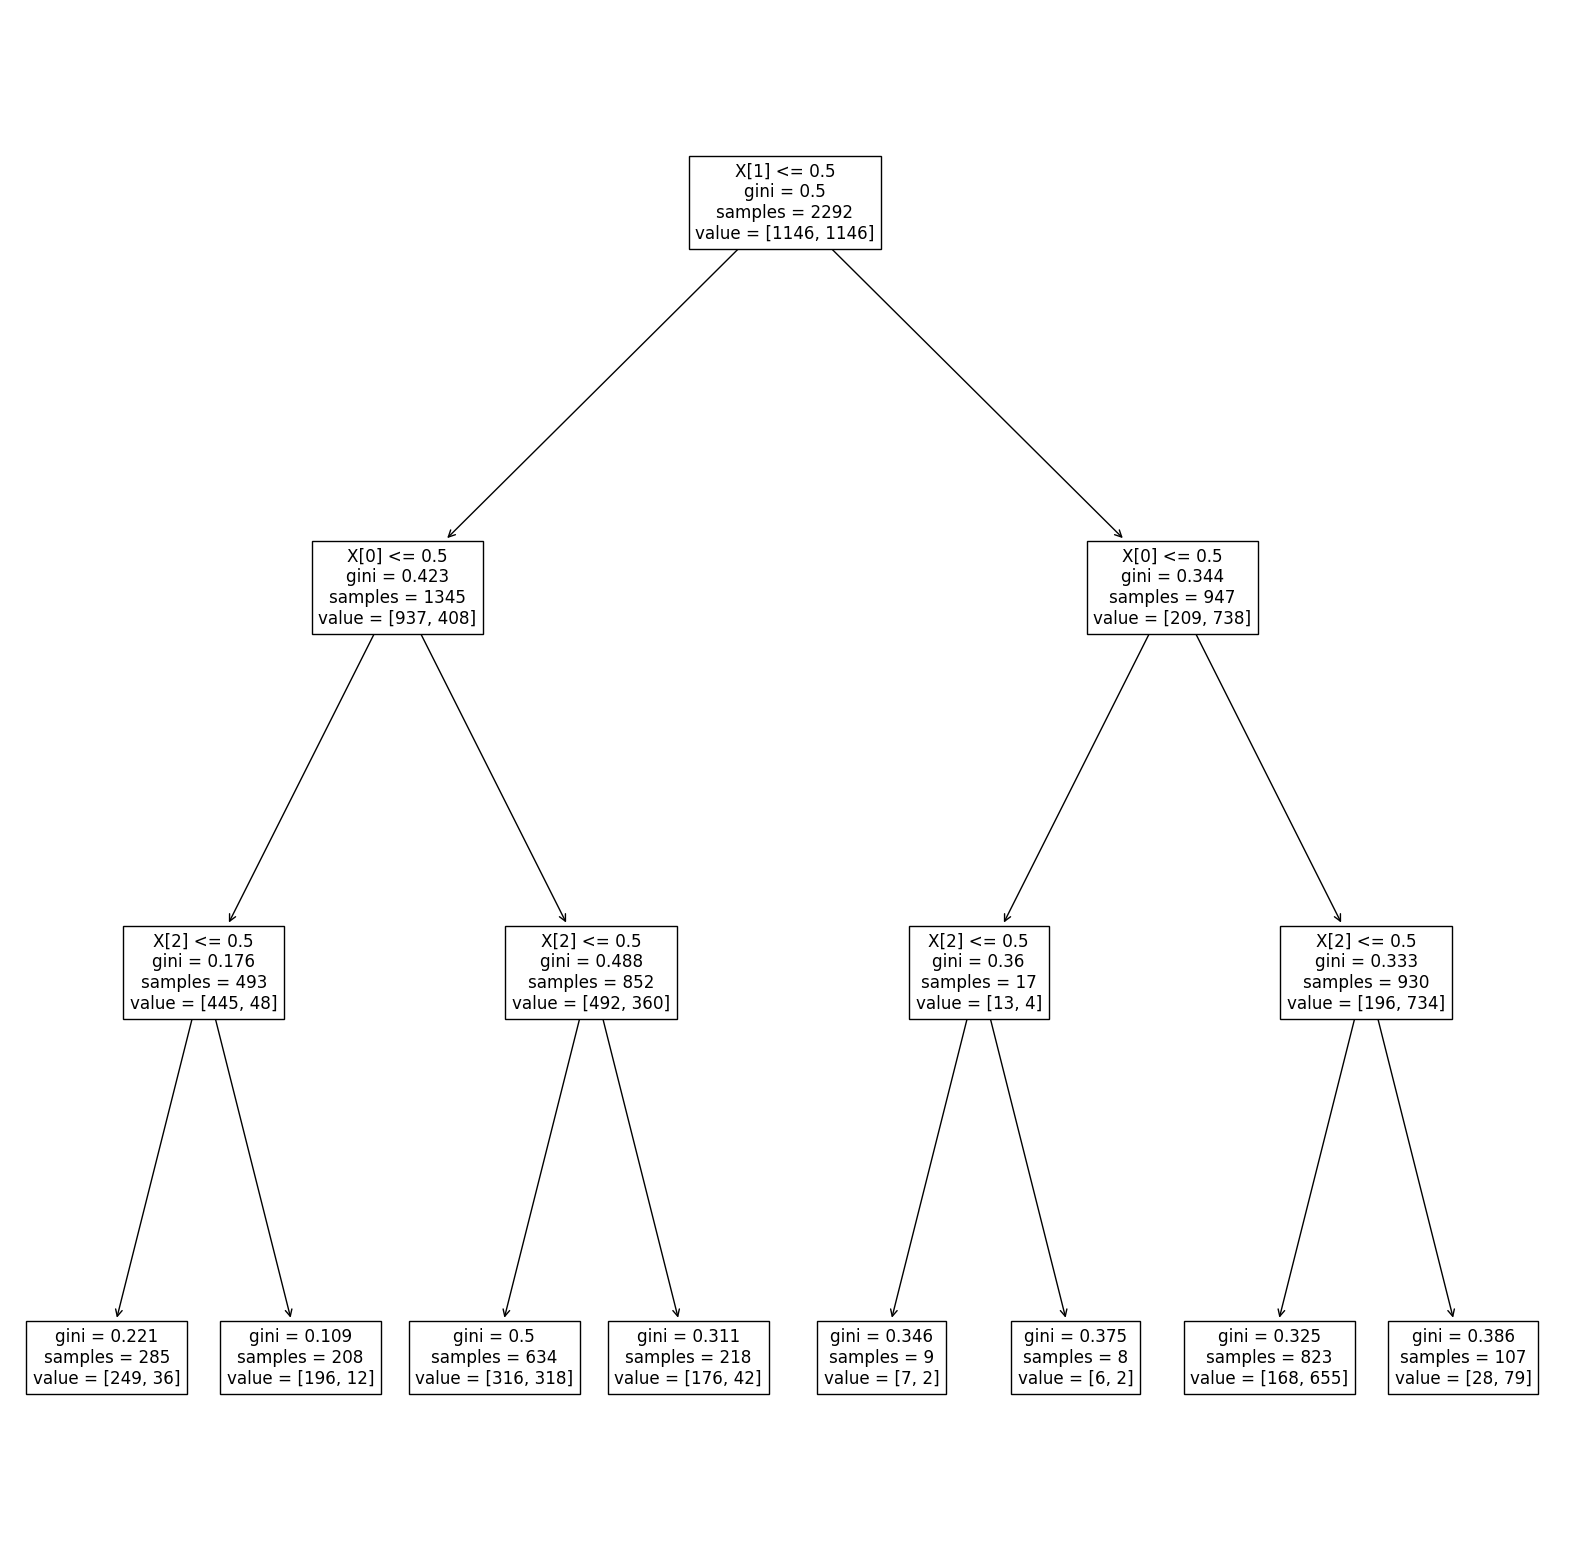

In [15]:
used_features = 'F17-F19'
run_all(used_features)